# Tucker: Number of components. 
Two methods are used to find the number of components into which to decompose the tensors. The methods used: DIFFIT, SVD.

These methods are applied both to the real patient data as well as the simulated data for verification purposes.

In [35]:
import numpy as np
import pandas as pd
import tensorly as tl
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd
import os

# Import tensors

In [36]:
# real data
tensor_70 = np.load('real_data/tensor_70.npy')
tensor_100 = np.load('real_data/tensor_100.npy')
tensor_200 = np.load('real_data/tensor_200.npy')
tensor_300 = np.load('real_data/tensor_300.npy')
# simulated data
tensor_1 = np.load('simulated_data/tensor_1.npy')
tensor_2 = np.load('simulated_data/tensor_2.npy')

In [37]:
# we create a list with the tensors for more efficient coding
tensors_real = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_real_names = ['70', '100', '200', '300']
tensors_sim = [tensor_1, tensor_2]
tensor_sim_names = ['1', '2']

# Auxiliary funtions

The next cell is to activate/deactivate figure saving. The figures will be stored in the current file directory inside a newly generated `Results/Tucker Components` folders.

In [38]:
# Decide if we want to save the figures
save_figs=True # Set to False to not save them

In [39]:
def save_figure(fig, file_prefix,foldername=None):
    current_path = os.getcwd()
    if foldername==None:
        save_folder = os.path.join(current_path, f'Results/Tucker Components')
    else:
        save_folder = os.path.join(current_path, f'Results/Tucker Components/{foldername}')
    os.makedirs(save_folder, exist_ok=True)
    png_path = os.path.join(save_folder, f"{file_prefix}.png")
    pdf_path = os.path.join(save_folder, f"{file_prefix}.pdf")
    if save_figs==True:
        fig.savefig(png_path, bbox_inches='tight')
        fig.savefig(pdf_path, bbox_inches='tight')

In [40]:
# Set global font sizes
plt.rcParams.update({
    "font.size": 22,        # Default text size
    "axes.titlesize": 22,   # Title size
    "axes.labelsize": 22,   # X and Y label size
    "xtick.labelsize": 20,  # X tick labels
    "ytick.labelsize": 20,  # Y tick labels
    "legend.fontsize": 19,  # Legend text size
    "figure.titlesize": 23,  # Suptitle font size
    "lines.linewidth": 3,  # Increase line thickness
    "lines.markersize": 10    # Marker size (adjust as needed)
})

# DIFFIT

The first method is DIFIT, proposed originally by Timmerman and Kiers (2000). The results for this method will be stored in an `.xlsx` file saved in the current file directory.

In [7]:
def diffit_values(tensor):
    best_ranks = []
    best_fits = []
    valid_ranks = []
    
    for i in range(1, tensor.shape[0]+1):
        for j in range(1, tensor.shape[1]+1):
            for k in range(1, tensor.shape[2]+1):
                if i <= j*k and j <= i*k and k <= i*j:
                    valid_ranks.append([i, j, k])
    
    valid_ranks = np.array(valid_ranks)
    
    unique_s = np.unique(np.sum(valid_ranks, axis=1))
    
    for s in unique_s:
        ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]
    
        best_fit = 0
        best_rank = []
    
        for rank in ranks_s:
            core_tensor, factors = tucker(tensor, list(rank))
    
            reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))
    
            fit = 100 * (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)
    
            if fit > best_fit:
                best_fit = fit
                best_rank = rank
    
        best_ranks.append(best_rank)
        best_fits.append(best_fit)

    return best_ranks, best_fits

In [8]:
def fits_to_diff_b(fits):
    diff = []
    diff.append(fits[0])
    for i in range(len(fits)-1):
        diff.append(fits[i+1]-fits[i])
    b = []
    n = len(diff)
    max_val = 0
    for i in range(n):
        if diff[n-1-i] > max_val:
            if max_val > 0:
                b.append(diff[n-1-i]/max_val)
                max_val = diff[n-1-i]
            else:
                b.append('-')
                max_val = diff[n-1-i]
        else:
            b.append('-')

    b_t = b[::-1]
    return diff, b_t

In [9]:
def diffit_to_writer(writer, ranks, fits, diff, b, name):
    df = pd.DataFrame(ranks, columns=['P', 'Q', 'R'])
    df['s'] = df[['P', 'Q', 'R']].sum(axis=1)
    df = df[['s', 'P', 'Q', 'R']]
    df['fit'] = fits
    df['dif'] = diff
    df['b'] = b
    df.to_excel(writer, sheet_name=name, index=False)

In [10]:
# real data
ranks_70, fits_70 = diffit_values(tensor_70)
diff_70, b_70 = fits_to_diff_b(fits_70)
ranks_100, fits_100 = diffit_values(tensor_100)
diff_100, b_100 = fits_to_diff_b(fits_100)
ranks_200, fits_200 = diffit_values(tensor_200)
diff_200, b_200 = fits_to_diff_b(fits_200)
ranks_300, fits_300 = diffit_values(tensor_300)
diff_300, b_300 = fits_to_diff_b(fits_300)
# simulated data
ranks_1, fits_1 = diffit_values(tensor_1)
diff_1, b_1 = fits_to_diff_b(fits_1)
ranks_2, fits_2 = diffit_values(tensor_2)
diff_2, b_2 = fits_to_diff_b(fits_2)
# output
with pd.ExcelWriter('DIFFIT.xlsx', engine='openpyxl', mode='w') as writer:
    diffit_to_writer(writer, ranks_70, fits_70, diff_70, b_70, "tensor_70")
    diffit_to_writer(writer, ranks_100, fits_100, diff_100, b_100, "tensor_100")
    diffit_to_writer(writer, ranks_200, fits_200, diff_200, b_200, "tensor_200")
    diffit_to_writer(writer, ranks_300, fits_300, diff_300, b_300, "tensor_300")
    diffit_to_writer(writer, ranks_1, fits_1, diff_1, b_1, "tensor_1")
    diffit_to_writer(writer, ranks_2, fits_2, diff_2, b_2, "tensor_2")

# SVD 

The second method is applying Singular Value Decomposition (SVD) to the matricised tensors and the using the reconstruction error to pick the most relevant singular values, which will be designated as the number of components for the decomposition.

In [41]:
def error(original, res):
    """Computes the error difference"""
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

def reconstruction_errors(ranks, U, S, Vt, matricized):
    """Computes the reconstruction error"""
    errors=np.zeros_like(ranks, dtype=float)
    for i, r in enumerate(ranks):
        reconstructed = (U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :])
        errors[i] = error(matricized, reconstructed)
    return errors

In [42]:
def compute_svd_ranks(tensor, tensor_name, error_threshold=0.05):
    """
    Computes the optimal rank for each mode using SVD, selecting ranks based on reconstruction error.
    Highlights selected singular values in the bar plots.
    """
    thres_rank = []

    # Define plots (Reconstruction error and singular values)
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    fig.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
    # fig.suptitle(f"Reconstruction Error for tensor_{tensor_name}", y=1.12)

    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 3))
    fig2.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
    # fig2.suptitle(f"Singular Values for tensor_{tensor_name}", y=1.12)

    # Find the number of components per each mode
    for mode in range(tl.ndim(tensor)):
        matricized = tl.unfold(tensor, mode)
        U, S, Vt = svd(matricized, full_matrices=False)
              
        ranks = np.arange(1, len(S) + 1)

        errors = reconstruction_errors(ranks, U, S, Vt, matricized)

        selected_rank = np.where(errors < error_threshold)[0][0] + 1  # Add 1 because index 0 corresponds to 1 component
        thres_rank.append(selected_rank)

        # Error plots
        ax = axes[mode]
        ax.plot(ranks, errors, color='b', marker='o', linestyle='-', label="Reconstruction Error", linewidth=3)
        ax.axvline(x=selected_rank, color='r', linestyle='--', label=f'Threshold ({error_threshold})', linewidth=3)
        ax.set_xlabel("Num of Comps.")
        ax.set_title(f"Mode {mode+1}")
        ax.grid(False)

        # Singular values plots (with highlighting)
        bar_colors = ['orange' if i < selected_rank else 'lightgray' for i in range(len(S))]
        axes2[mode].bar(np.arange(1, len(S) + 1), S, color=bar_colors)
        axes2[mode].set_xlabel('Singular Value')
        axes2[mode].set_title(f"Mode {mode+1}")
        axes2[mode].grid(False)

    # Set the same y-label for all subplots
    axes[0].set_ylabel("Error")
    axes2[0].set_ylabel('Magnitude')

    # Add legends to the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3)

    # Save figures
    save_figure(fig, f'tensor_{tensor_name}_{error_threshold}_reconstruction_error',foldername=f'tensor_{tensor_name}')
    save_figure(fig2, f'tensor_{tensor_name}_{error_threshold}_singular_values',foldername=f'tensor_{tensor_name}')

    plt.show()
    return thres_rank


In [43]:
def SVD_components(tensors, tensor_names, error_threshold=0.1):
    all_errors = []

    for i, tensor in enumerate(tensors):
        tensor_name = tensor_names[i]
        print(f'Results for tensor_{tensor_name} and error_threshold={error_threshold}')
        error_thres_ranks = compute_svd_ranks(tensor, tensor_name, error_threshold=error_threshold)
        all_errors.append(error_thres_ranks)

    return all_errors

## Real data

Results for tensor_70 and error_threshold=0.1


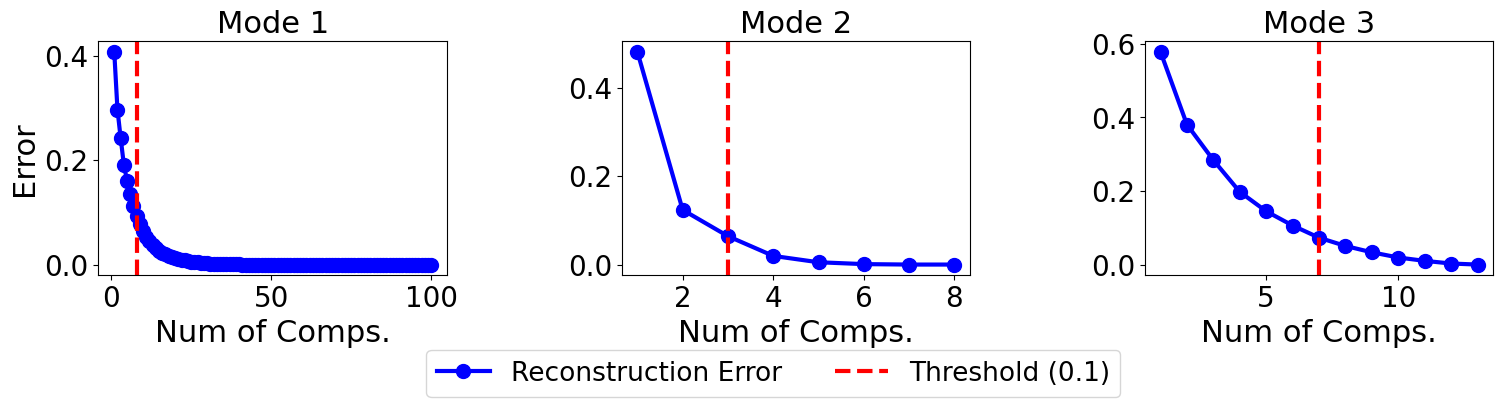

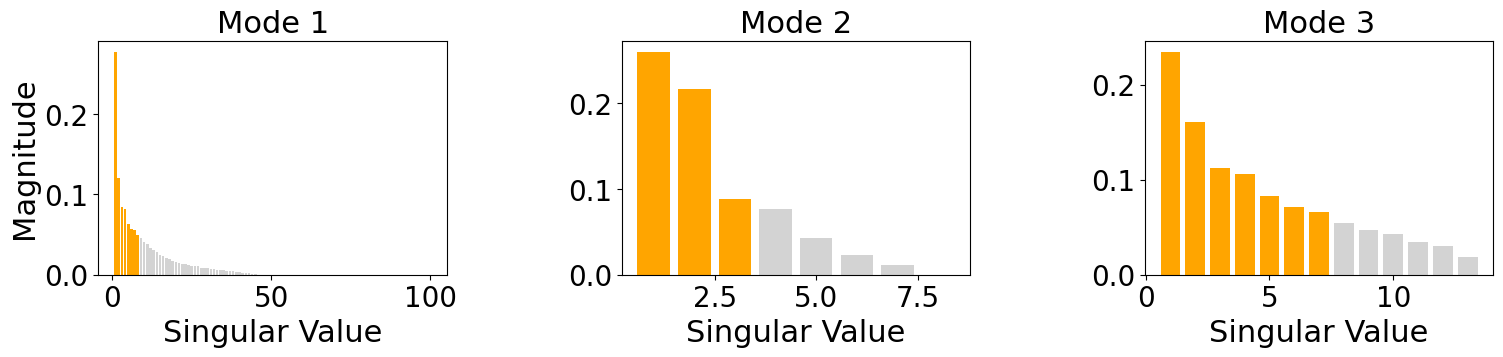

Results for tensor_100 and error_threshold=0.1


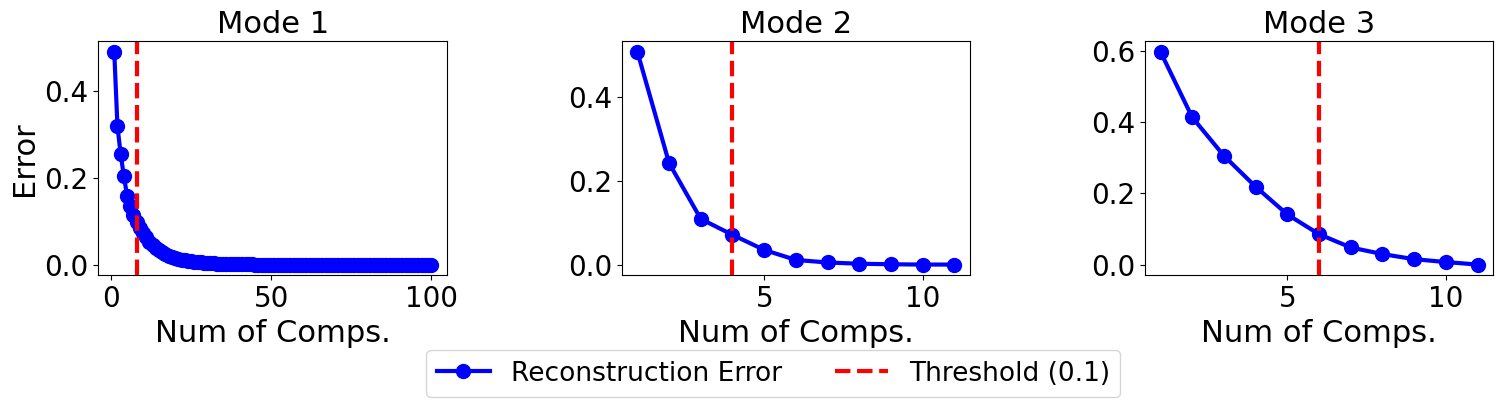

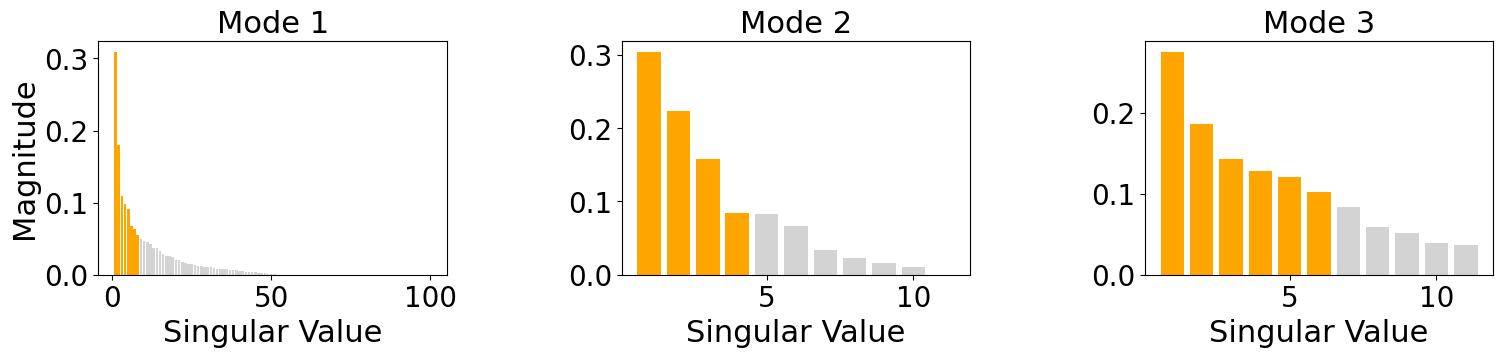

Results for tensor_200 and error_threshold=0.1


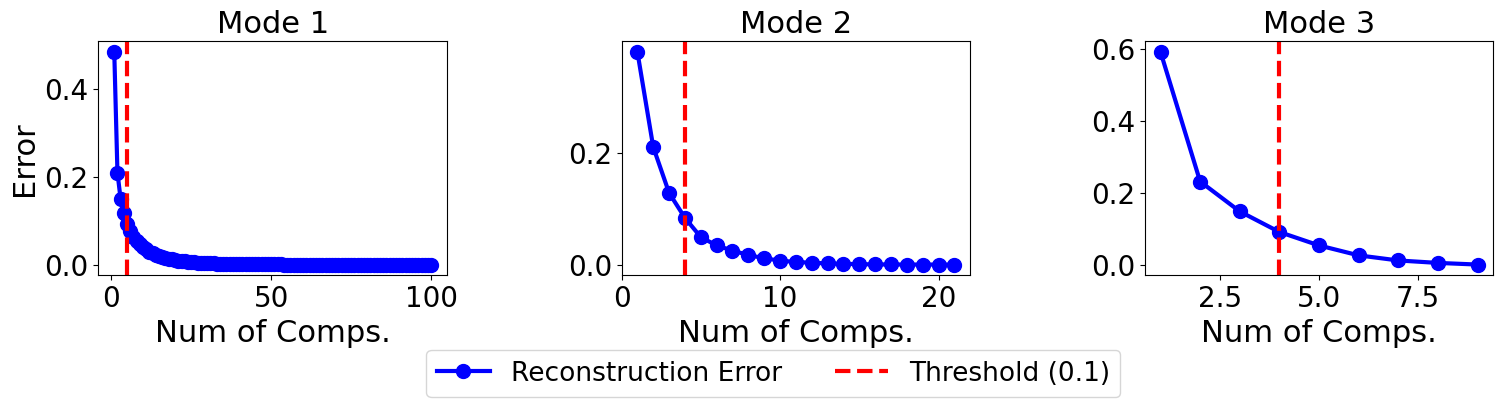

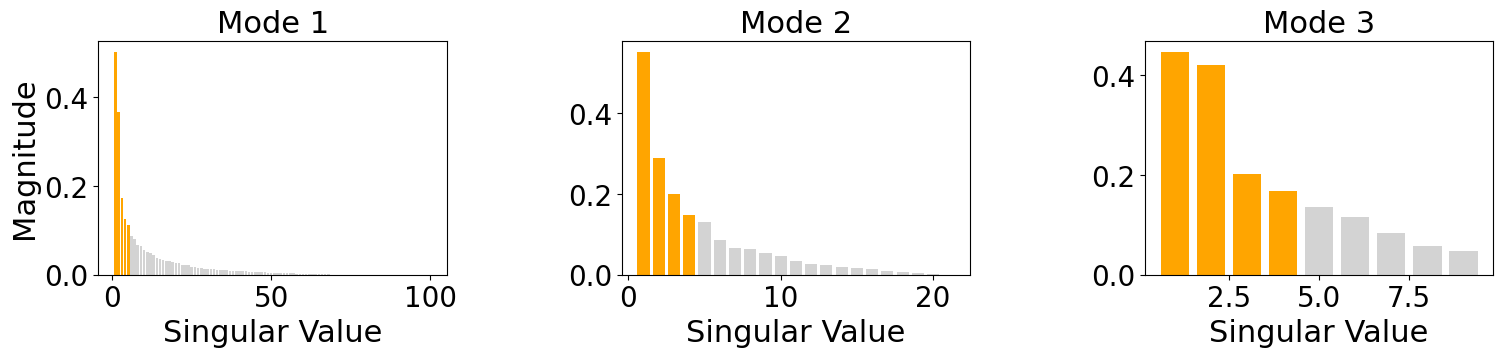

Results for tensor_300 and error_threshold=0.1


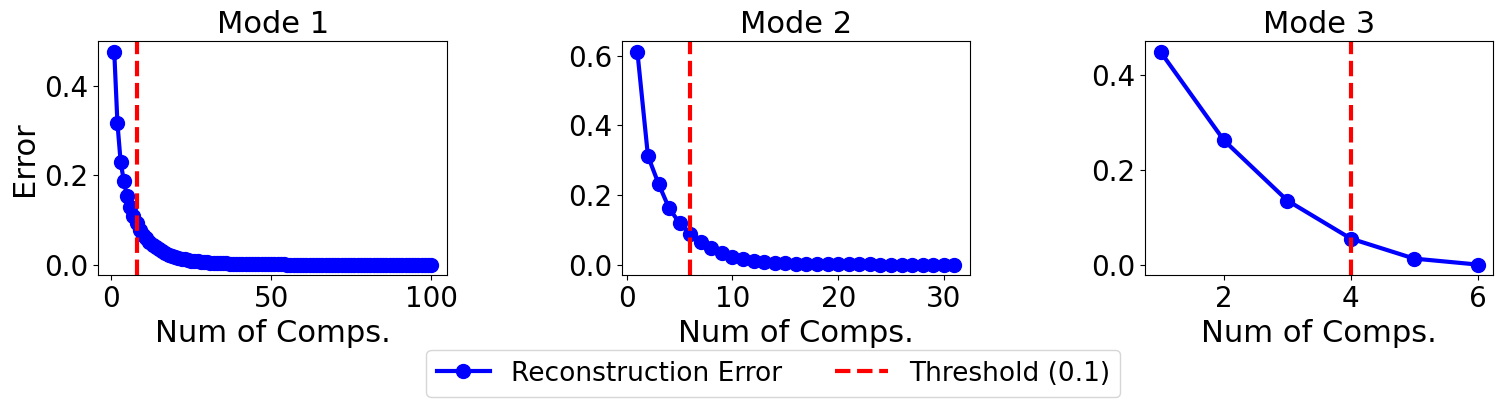

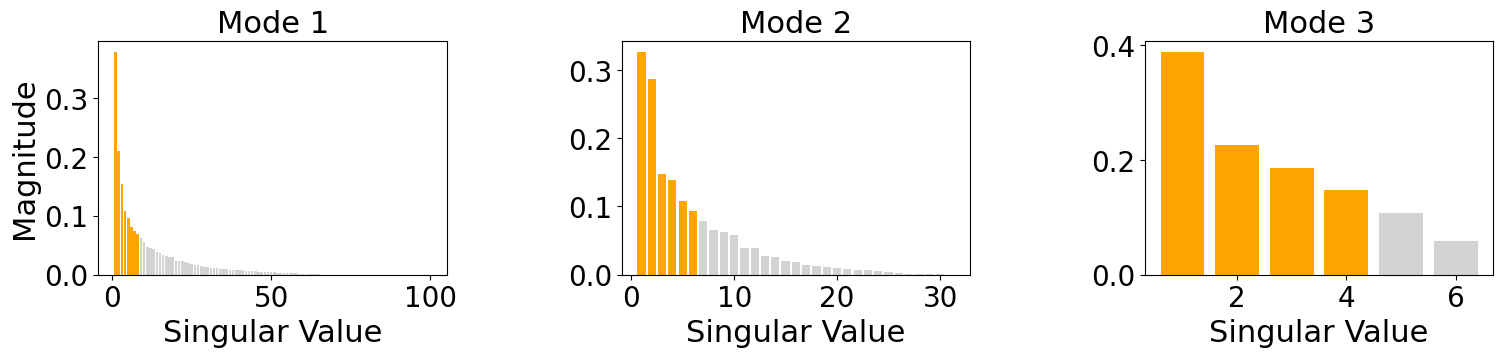

Results for tensor_70 and error_threshold=0.15


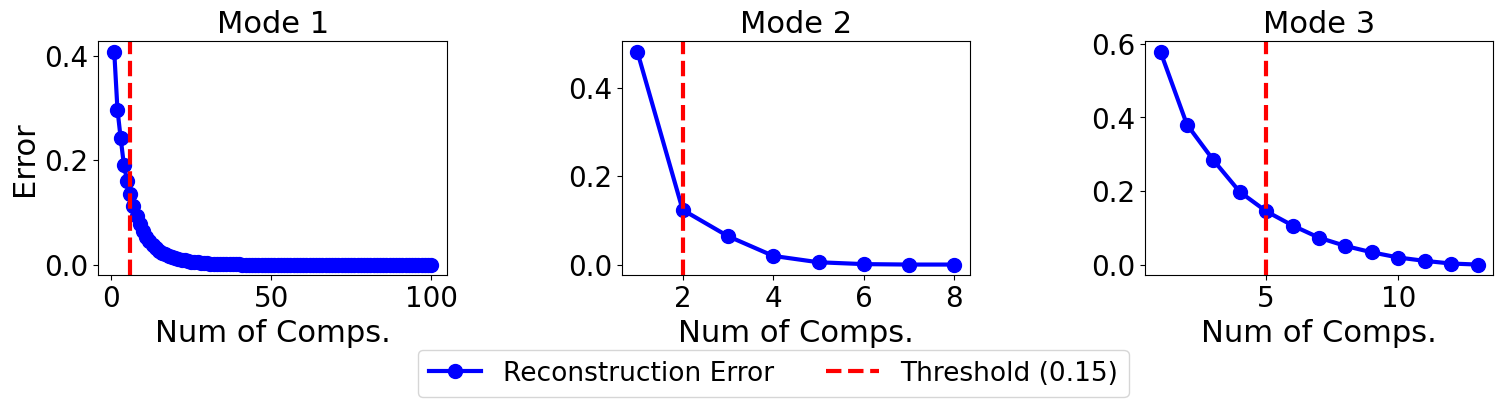

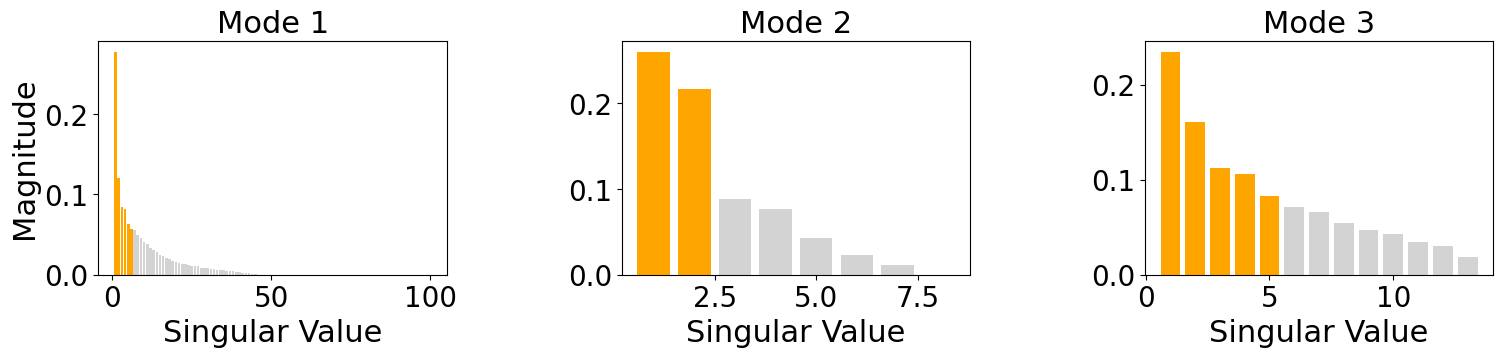

Results for tensor_100 and error_threshold=0.15


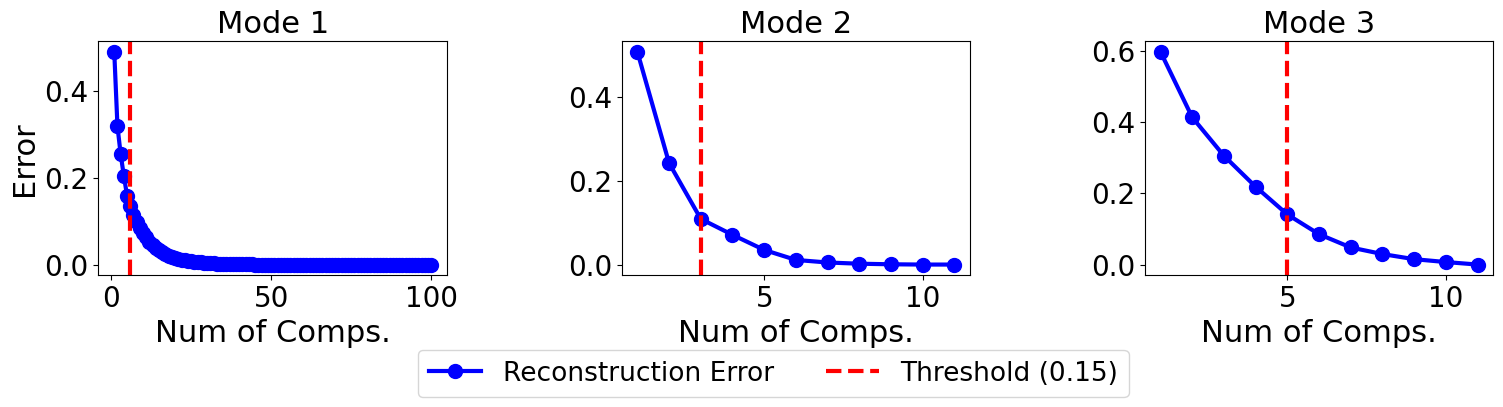

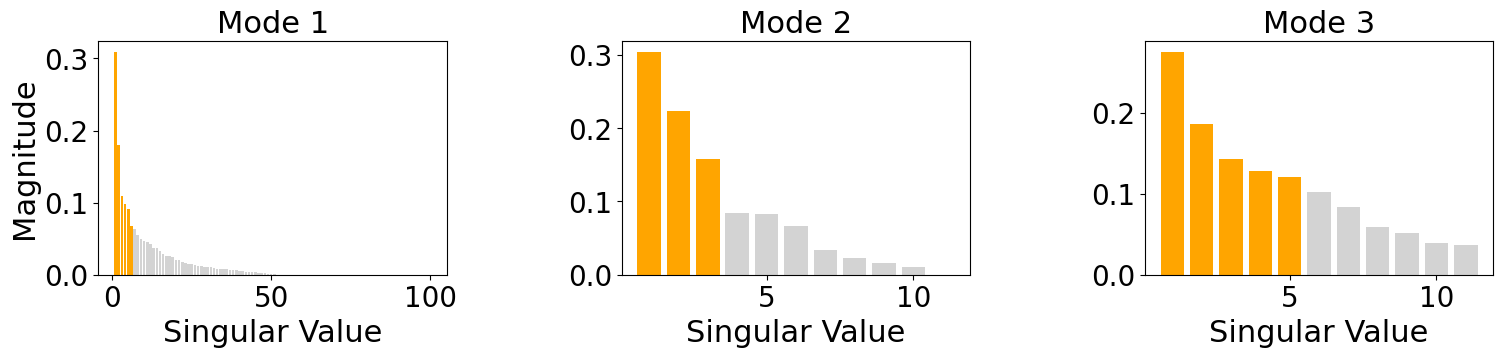

Results for tensor_200 and error_threshold=0.15


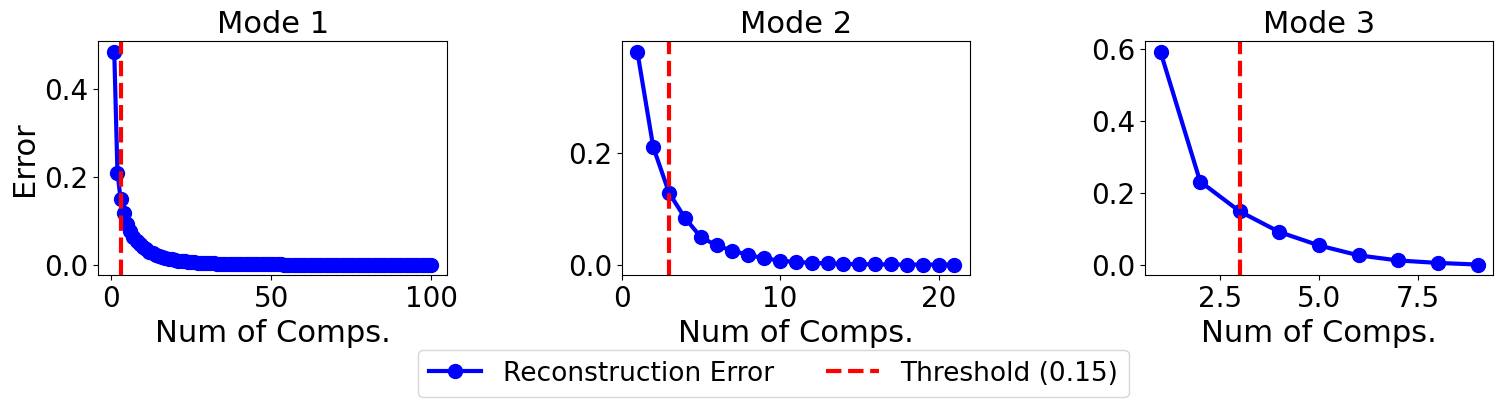

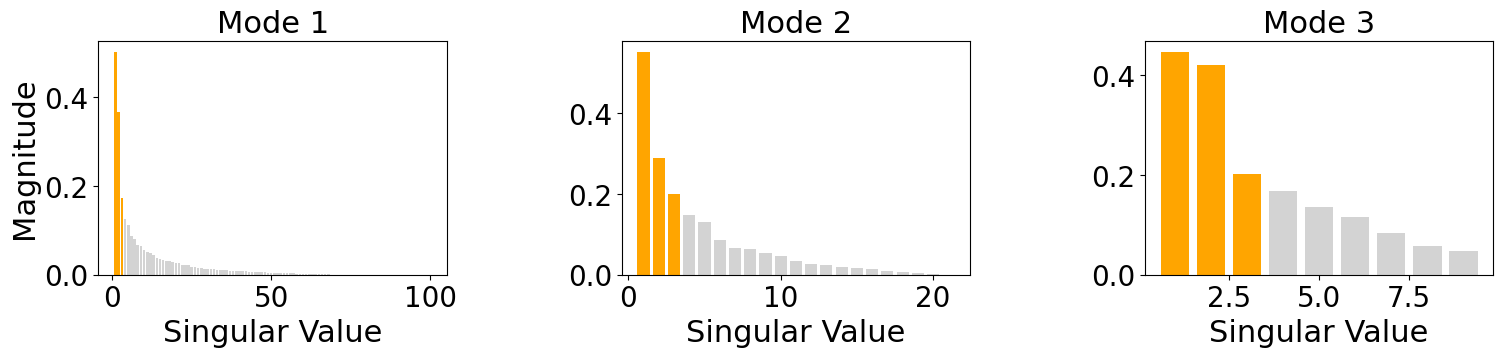

Results for tensor_300 and error_threshold=0.15


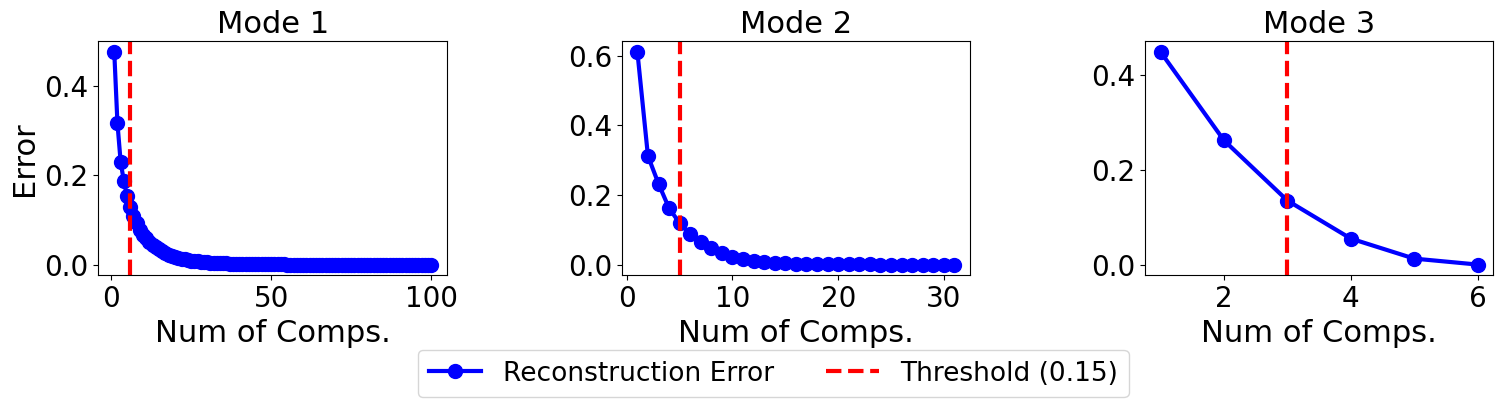

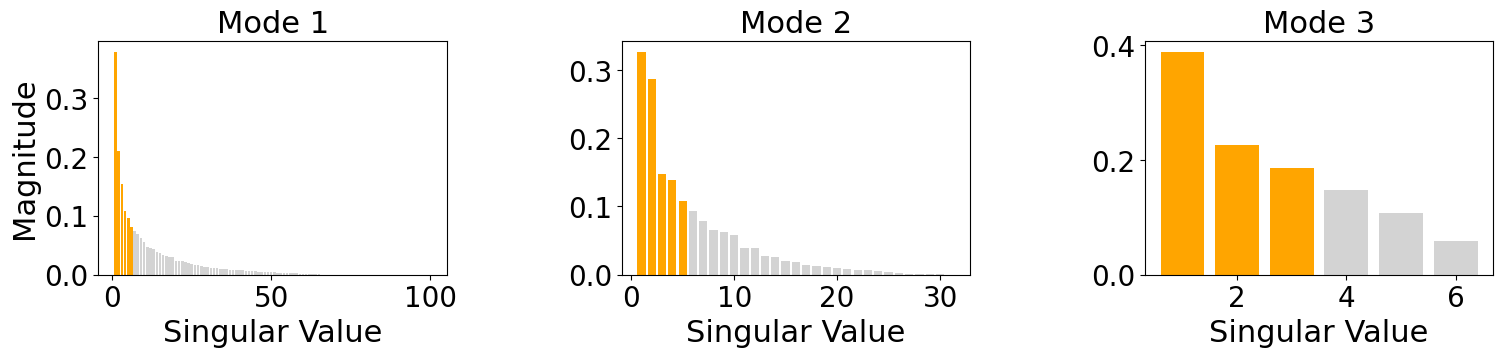

Results for tensor_70 and error_threshold=0.2


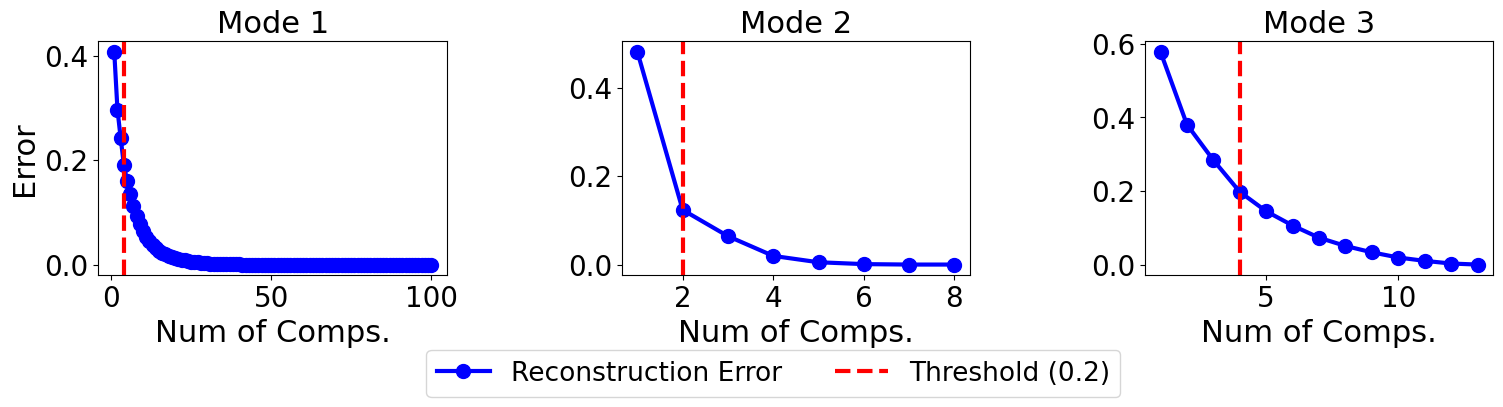

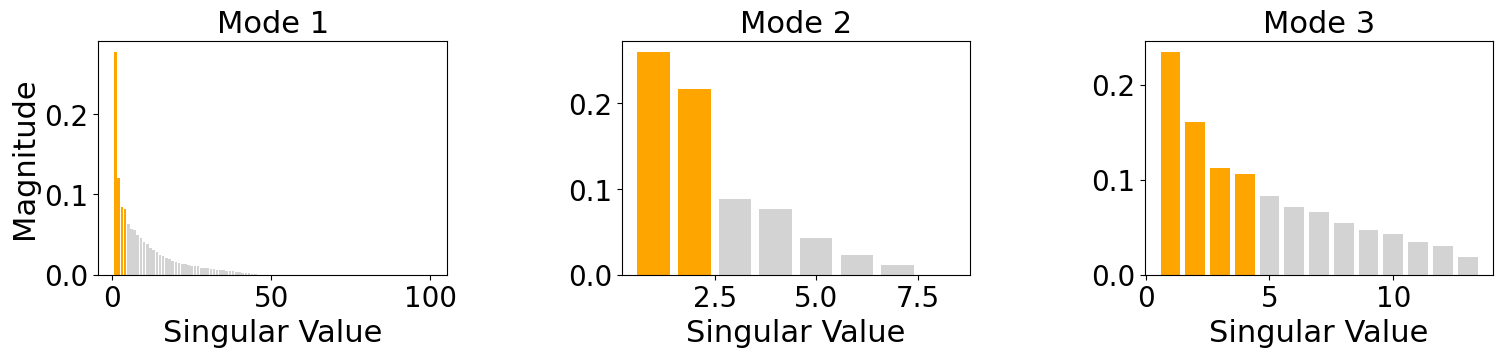

Results for tensor_100 and error_threshold=0.2


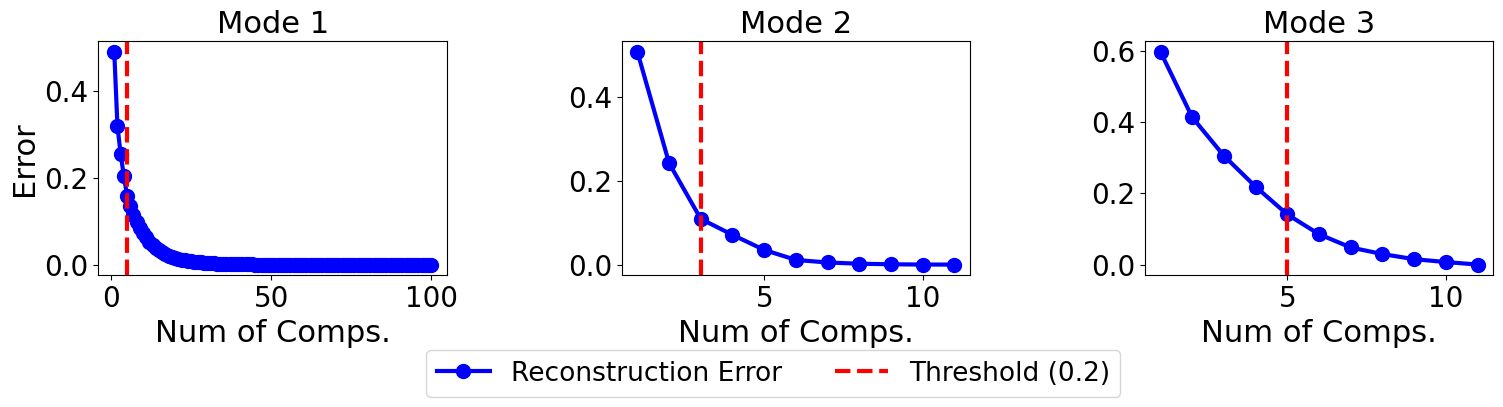

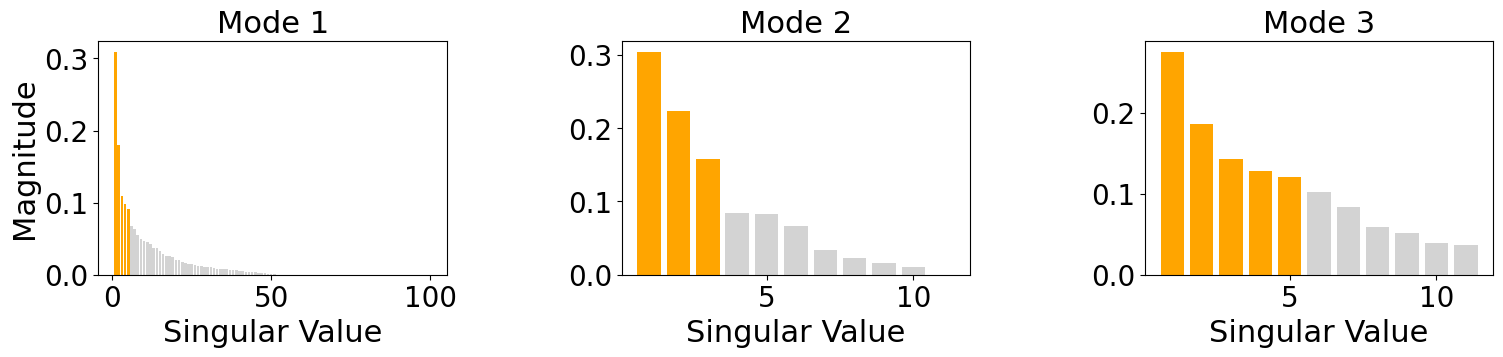

Results for tensor_200 and error_threshold=0.2


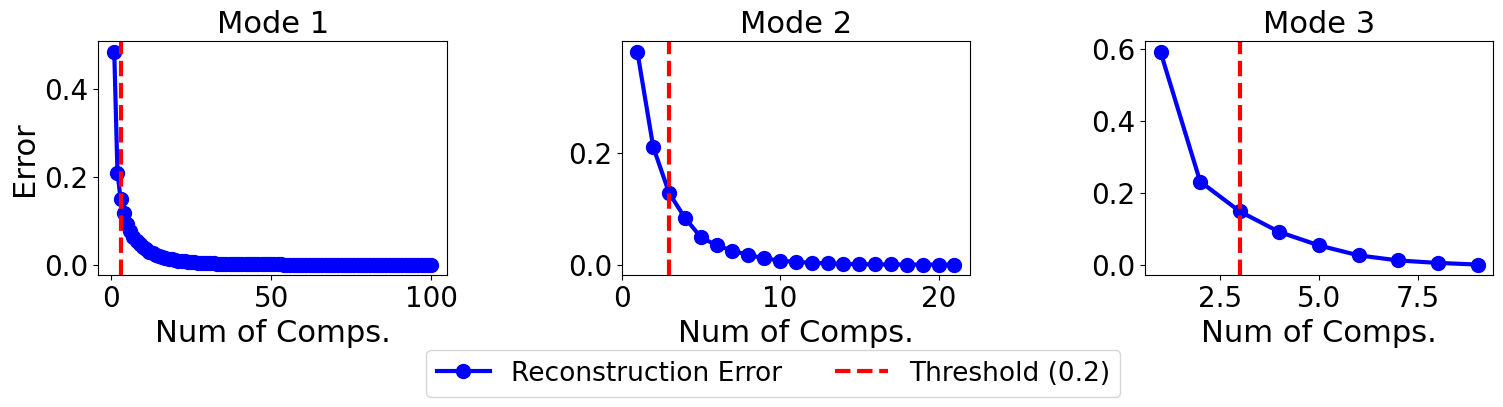

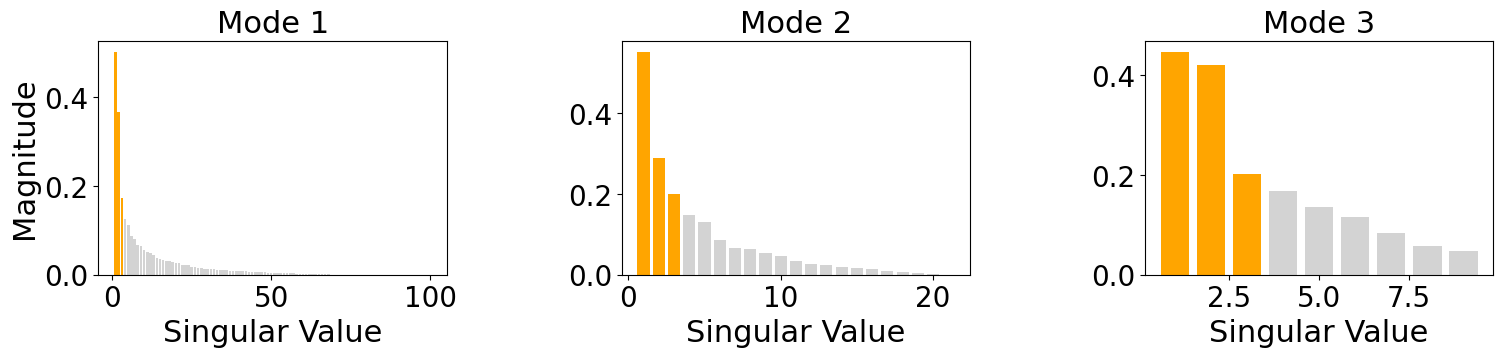

Results for tensor_300 and error_threshold=0.2


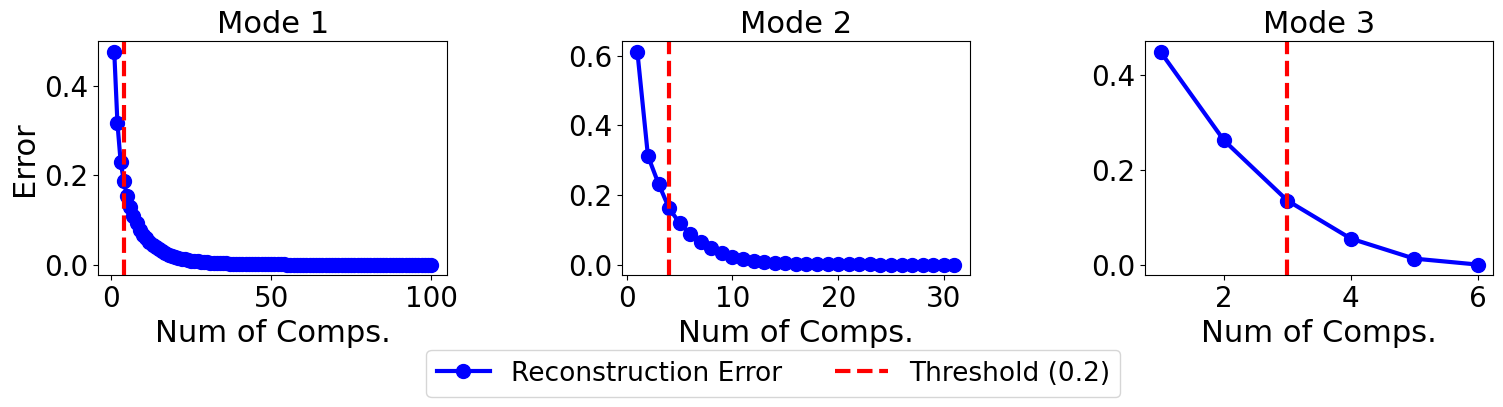

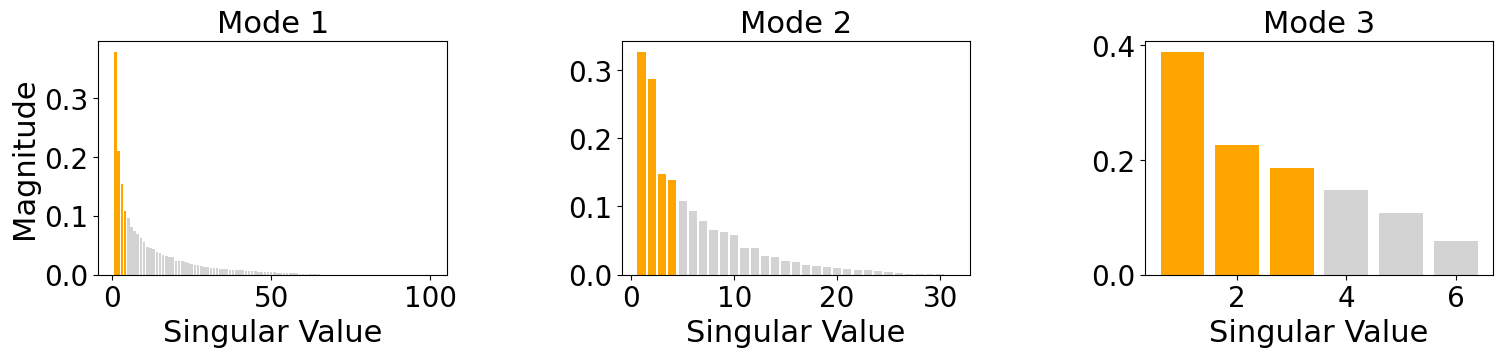

Results for tensor_70 and error_threshold=0.25


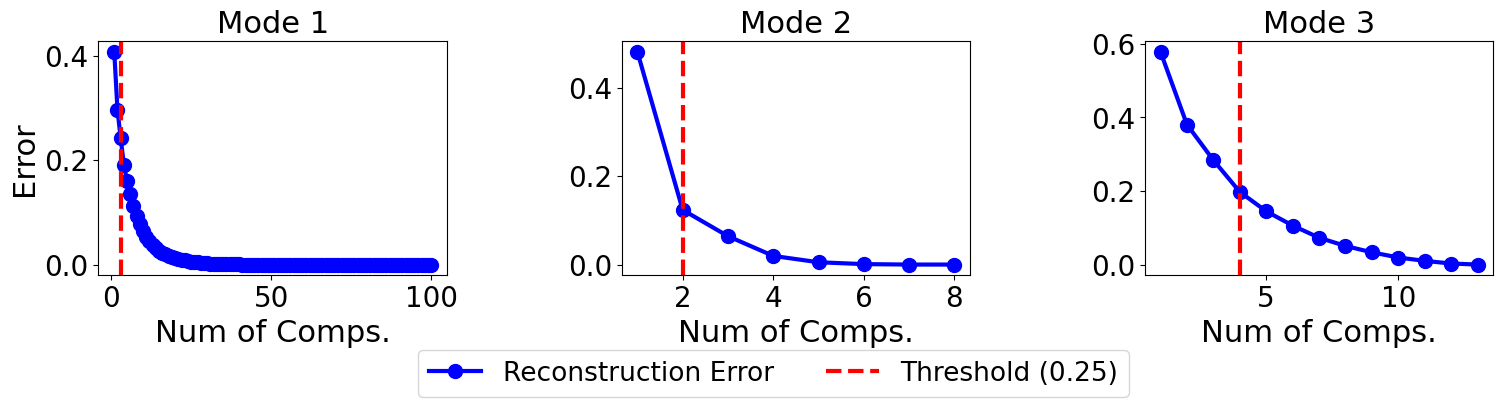

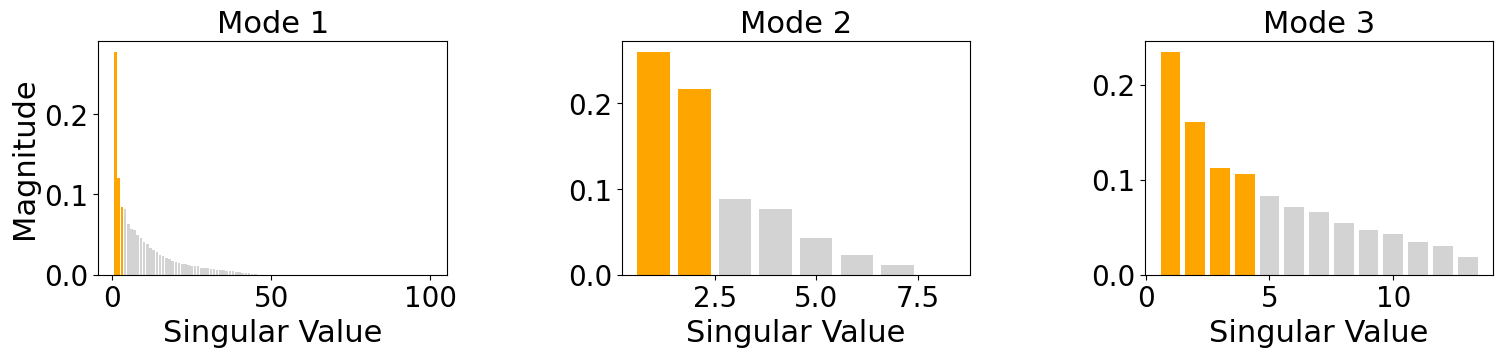

Results for tensor_100 and error_threshold=0.25


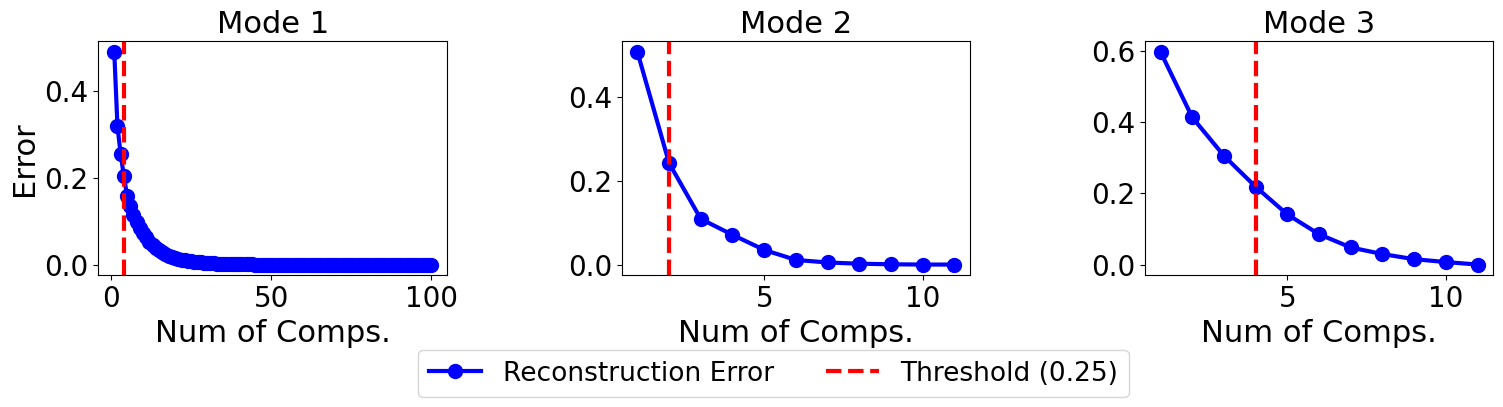

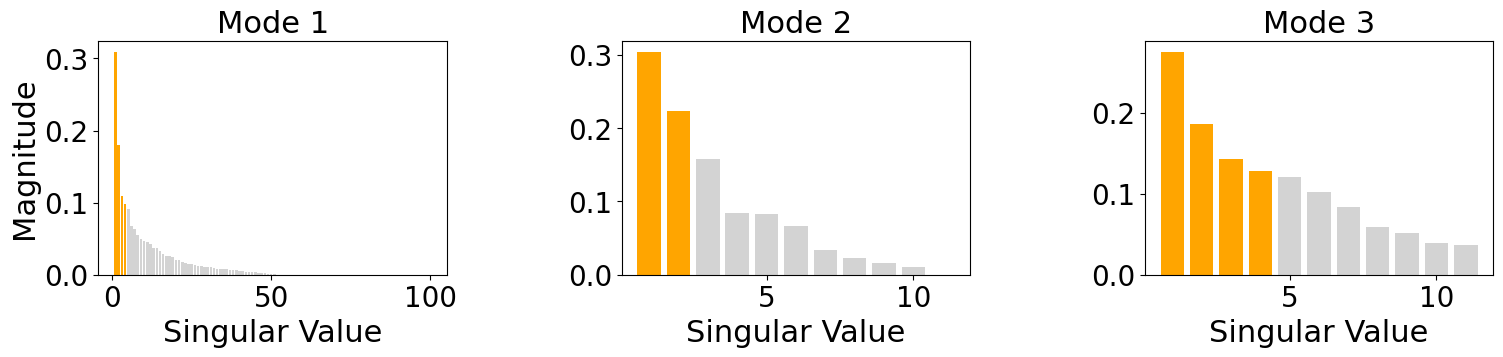

Results for tensor_200 and error_threshold=0.25


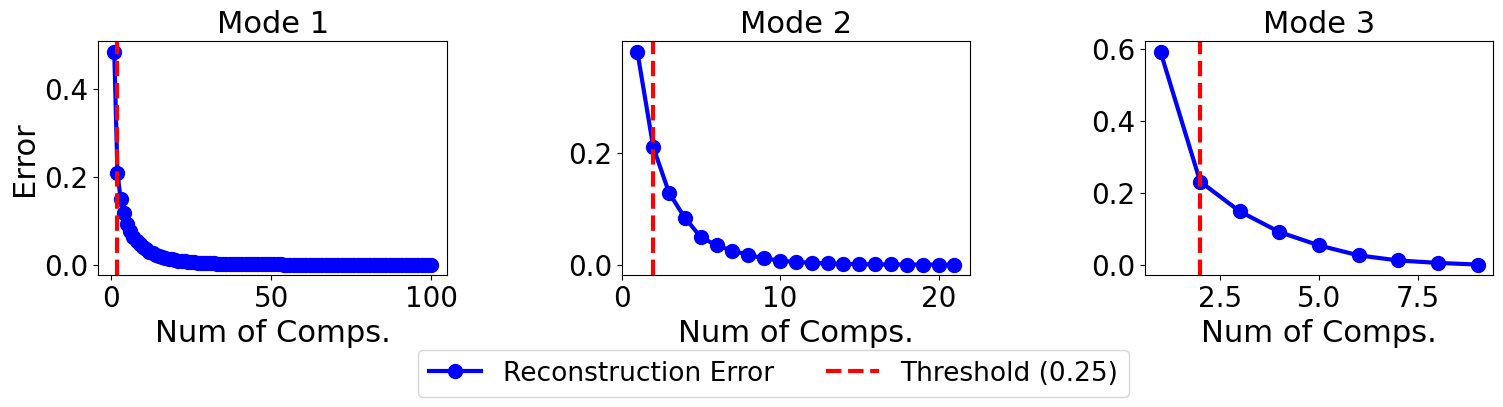

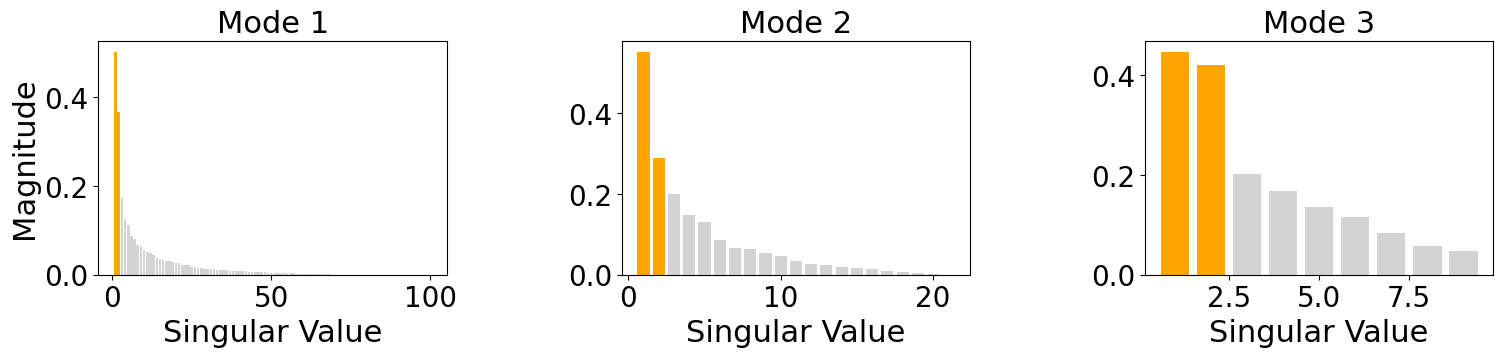

Results for tensor_300 and error_threshold=0.25


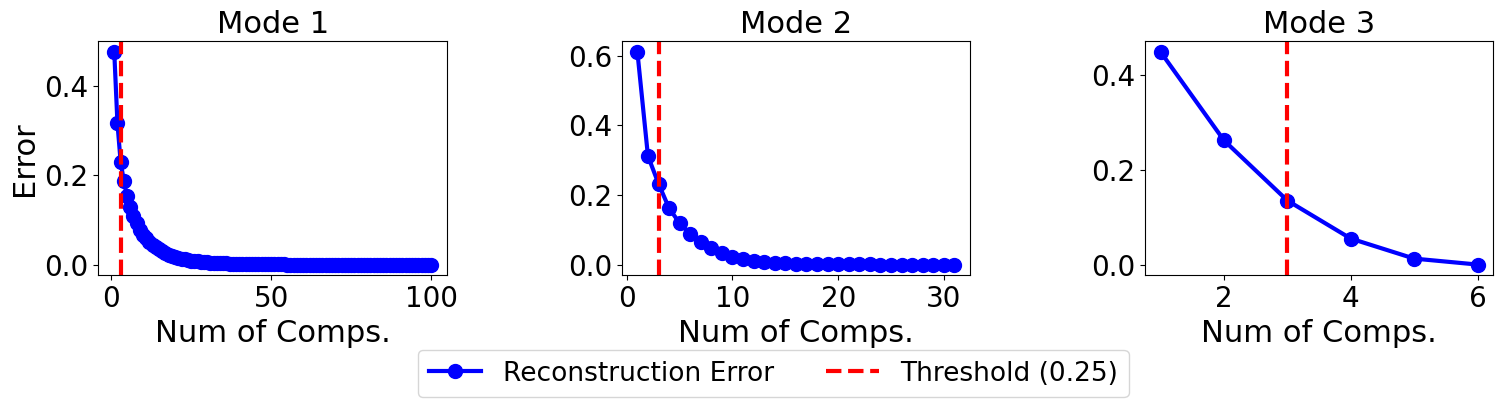

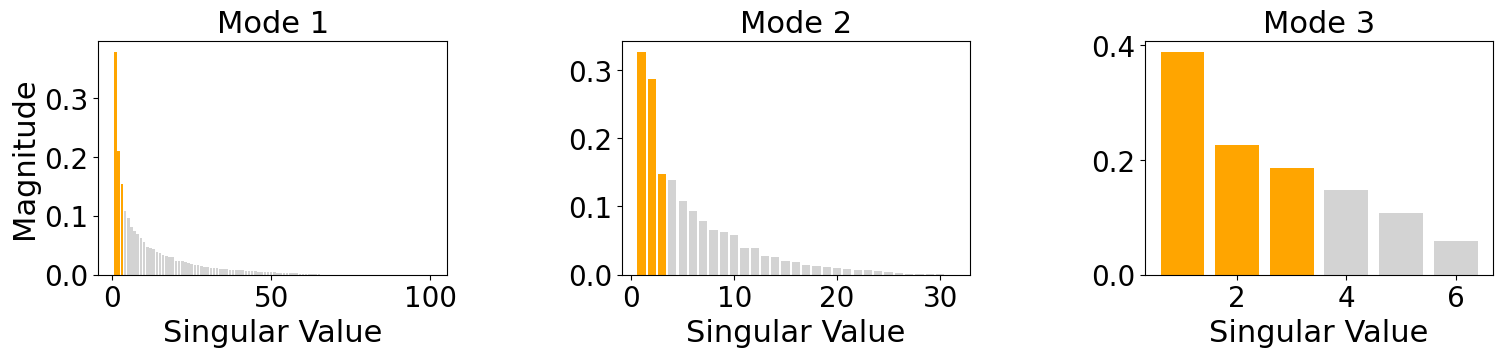

Results for tensor_70 and error_threshold=0.3


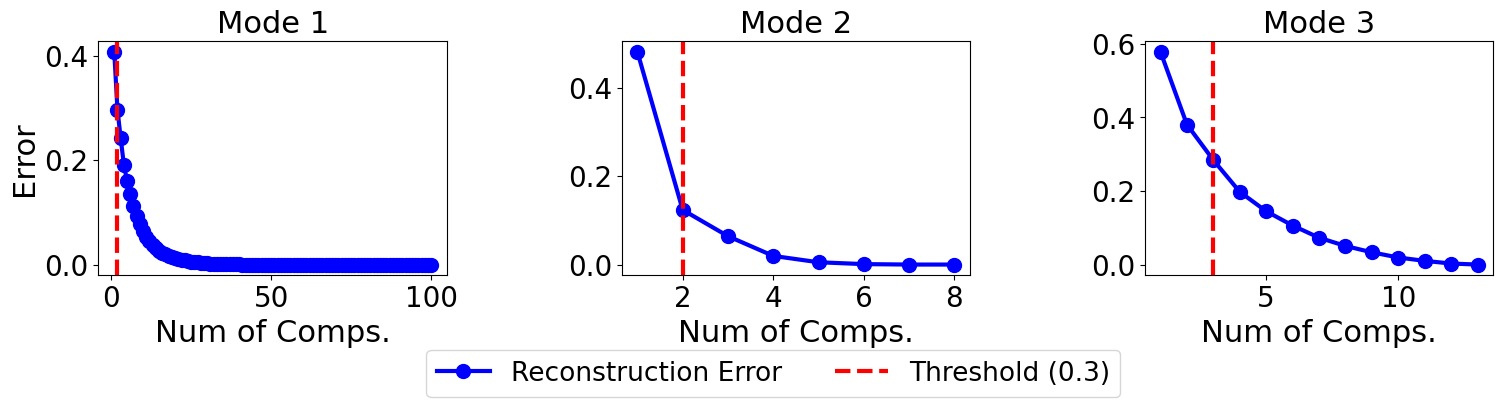

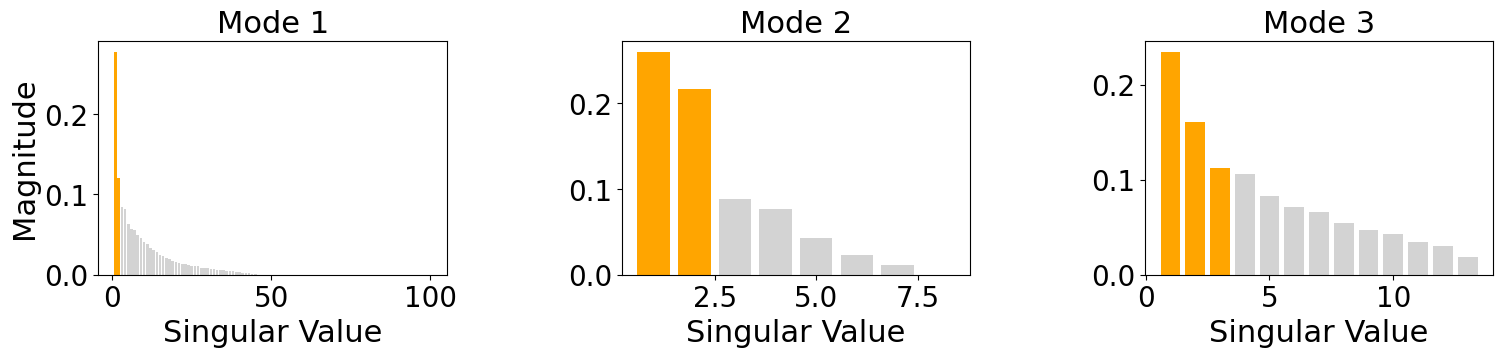

Results for tensor_100 and error_threshold=0.3


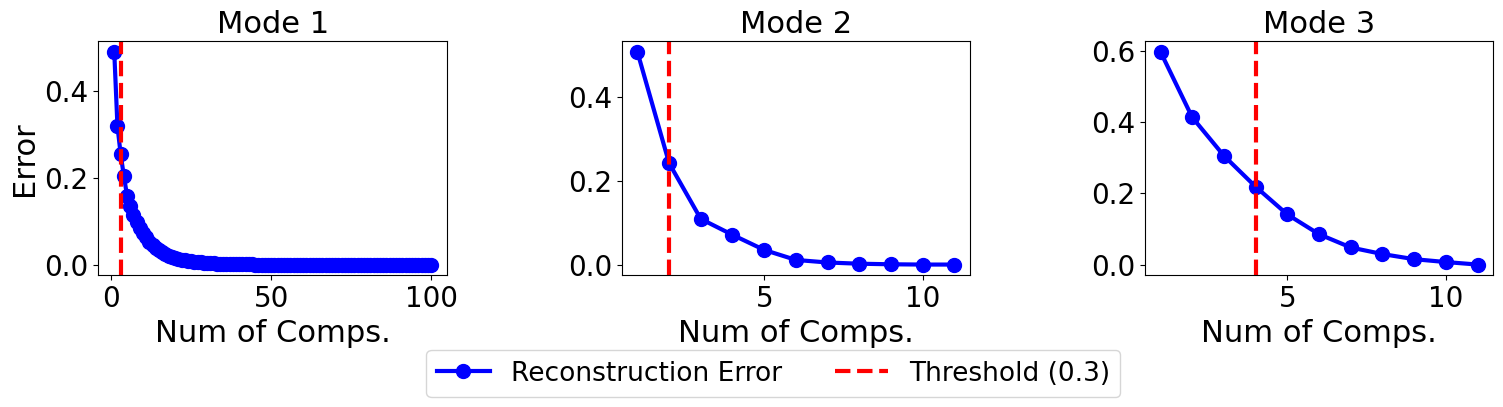

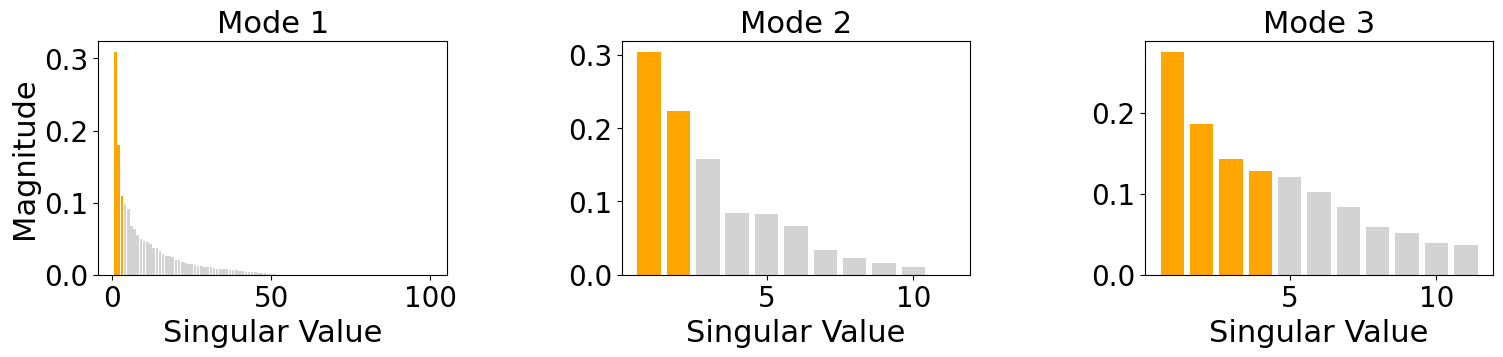

Results for tensor_200 and error_threshold=0.3


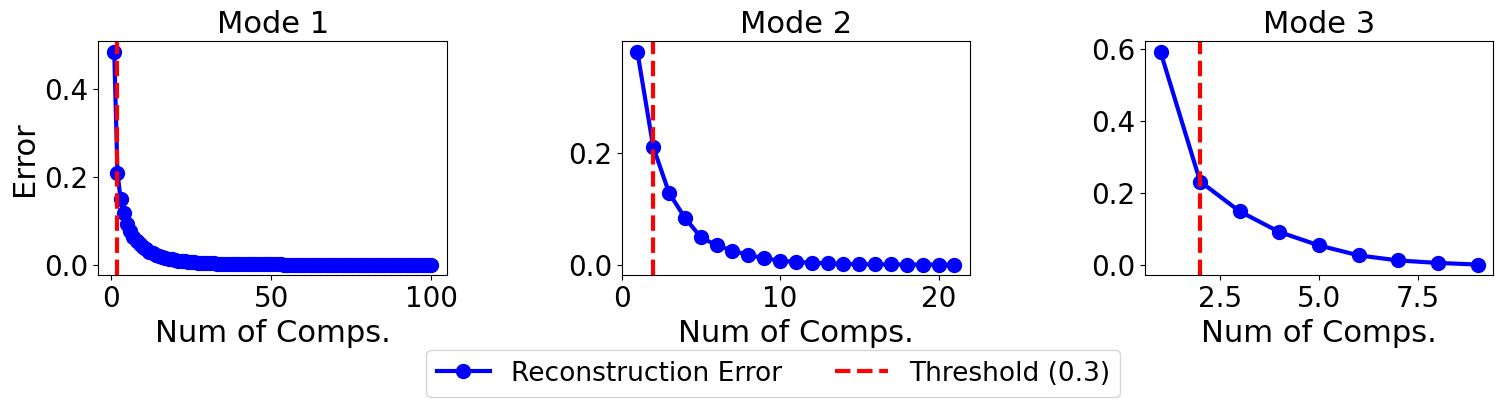

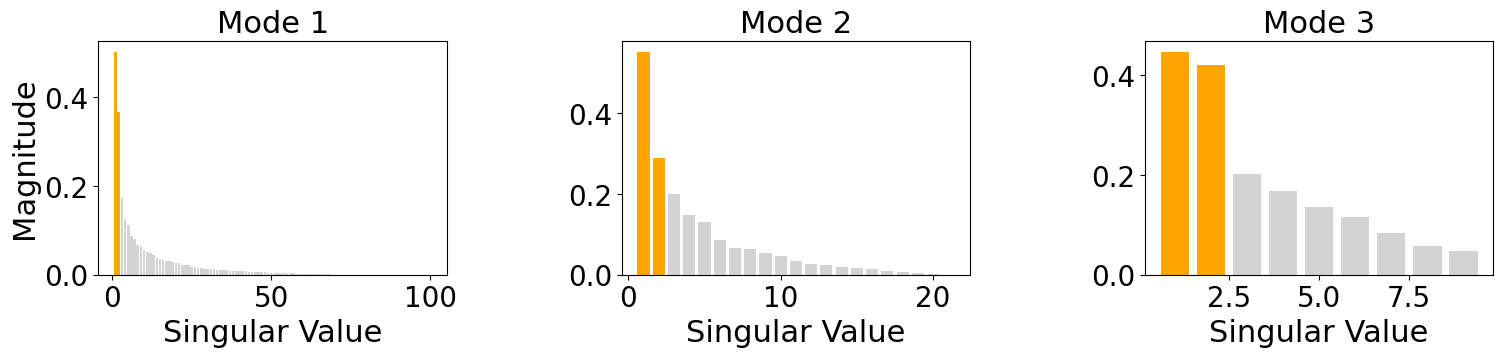

Results for tensor_300 and error_threshold=0.3


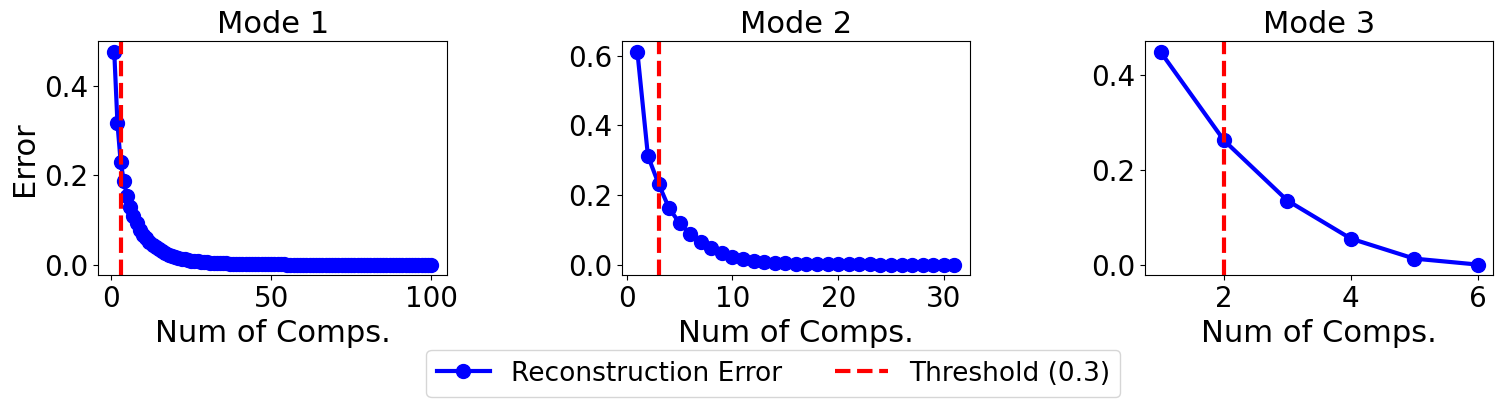

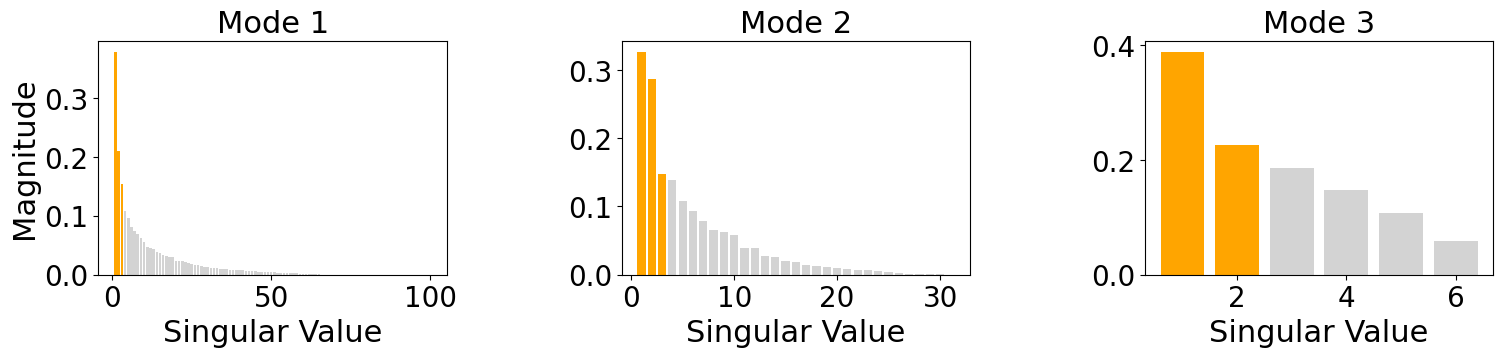

Results for tensor_70 and error_threshold=0.35


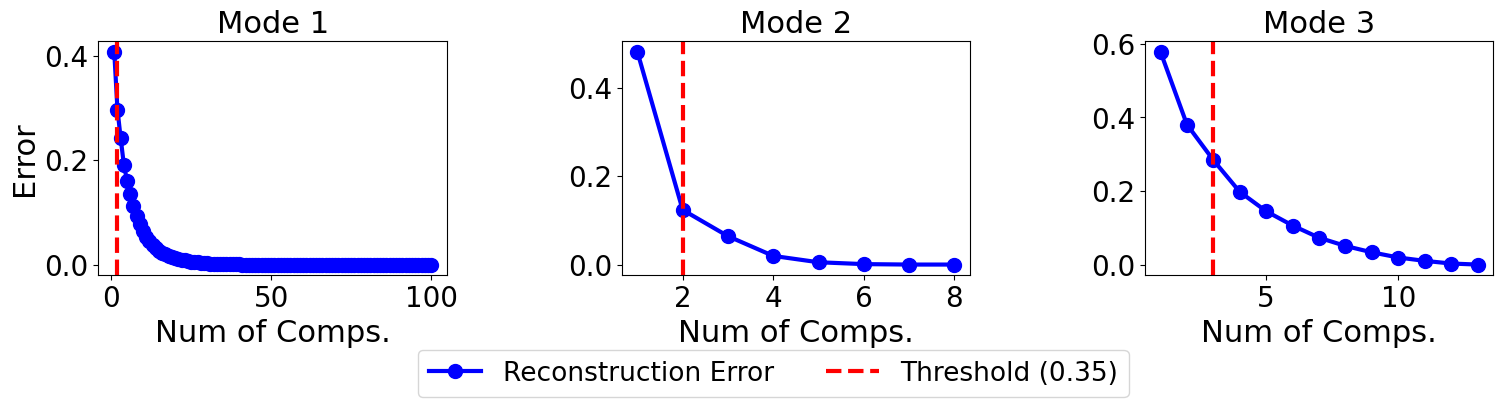

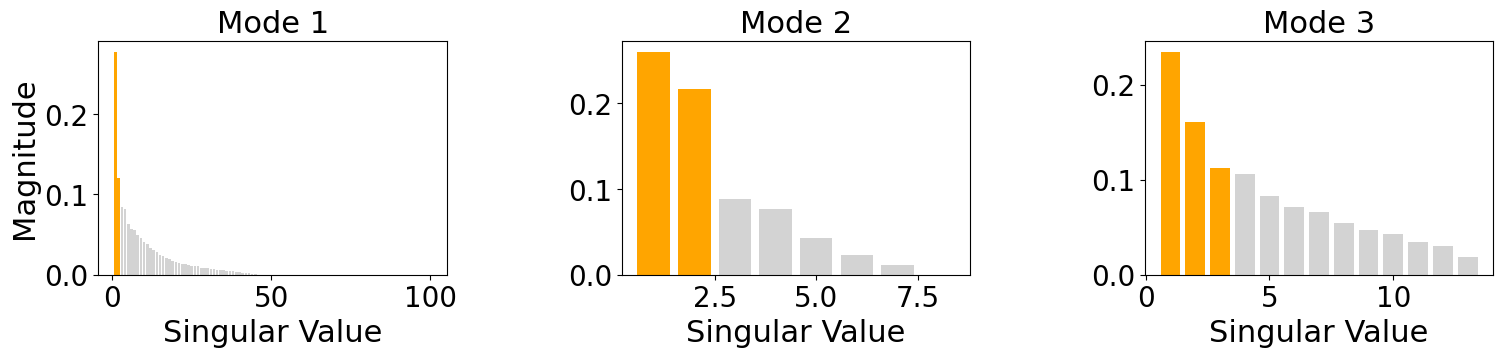

Results for tensor_100 and error_threshold=0.35


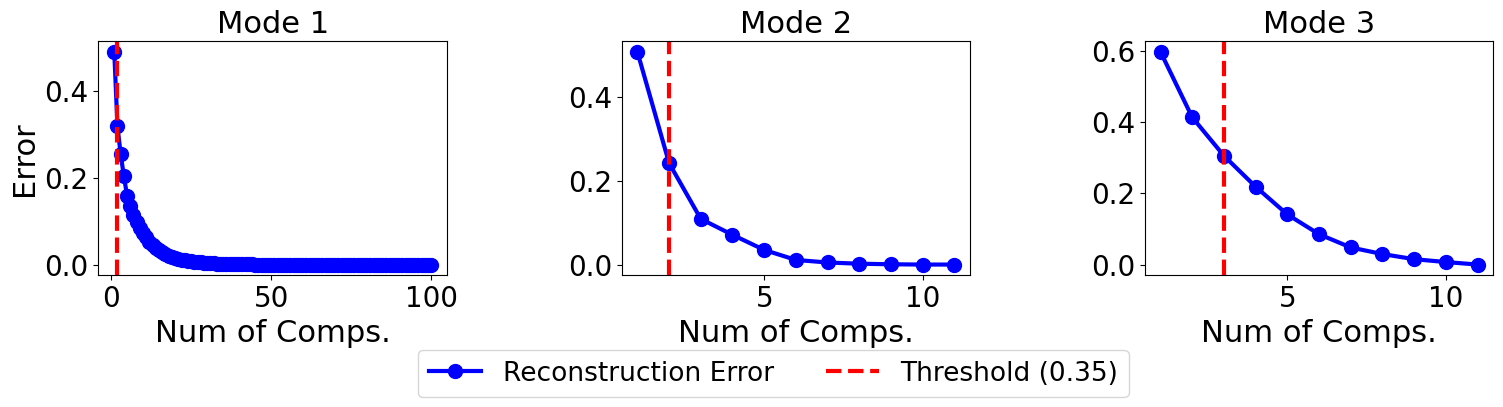

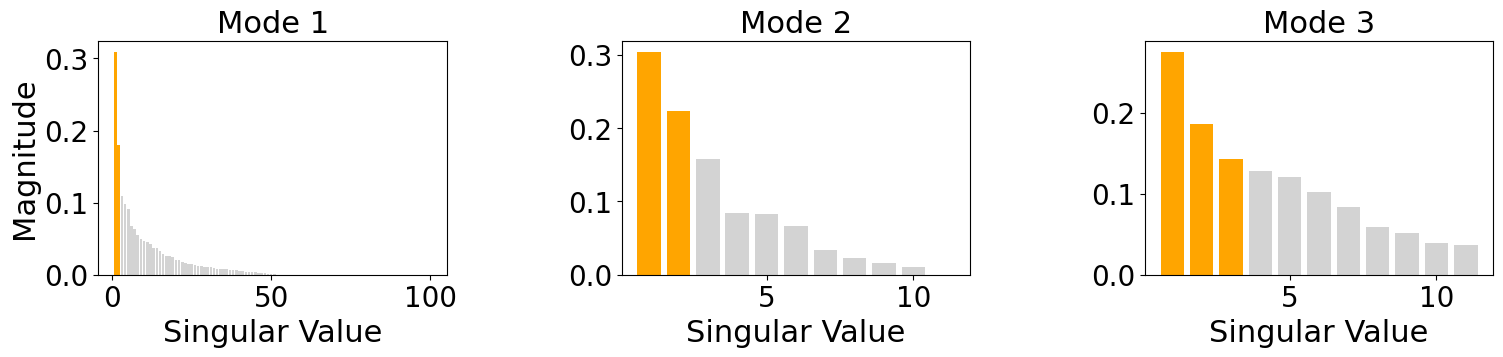

Results for tensor_200 and error_threshold=0.35


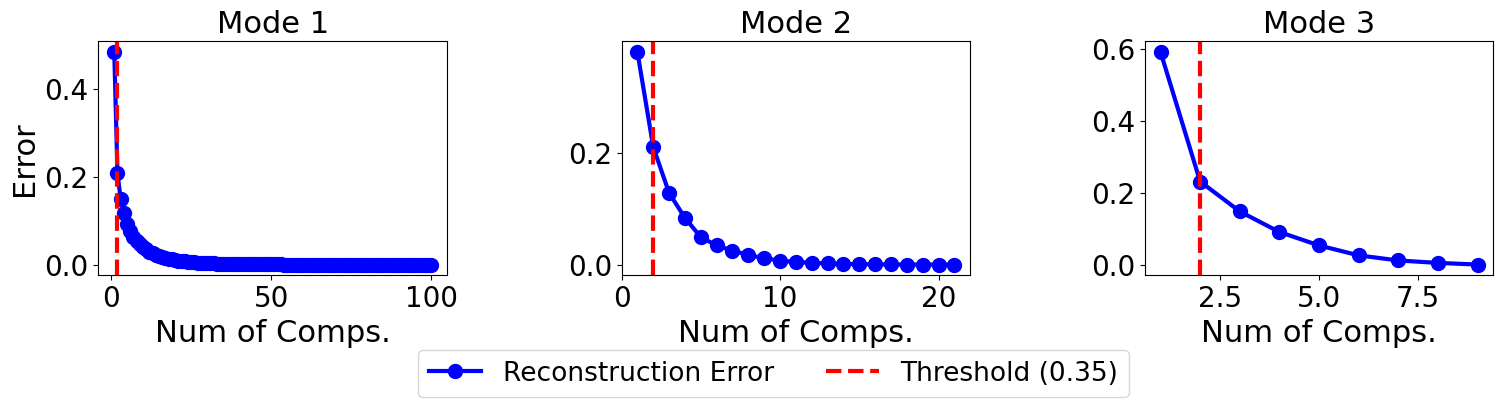

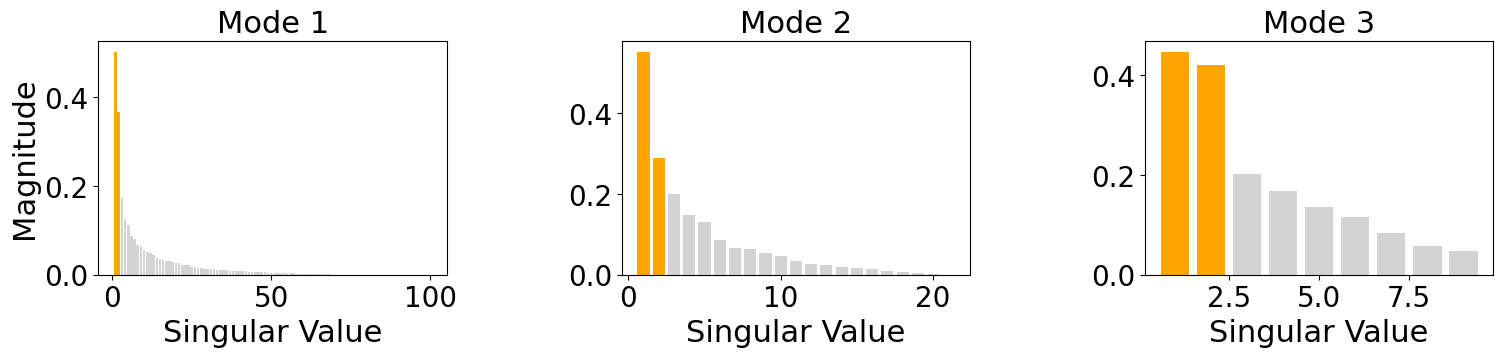

Results for tensor_300 and error_threshold=0.35


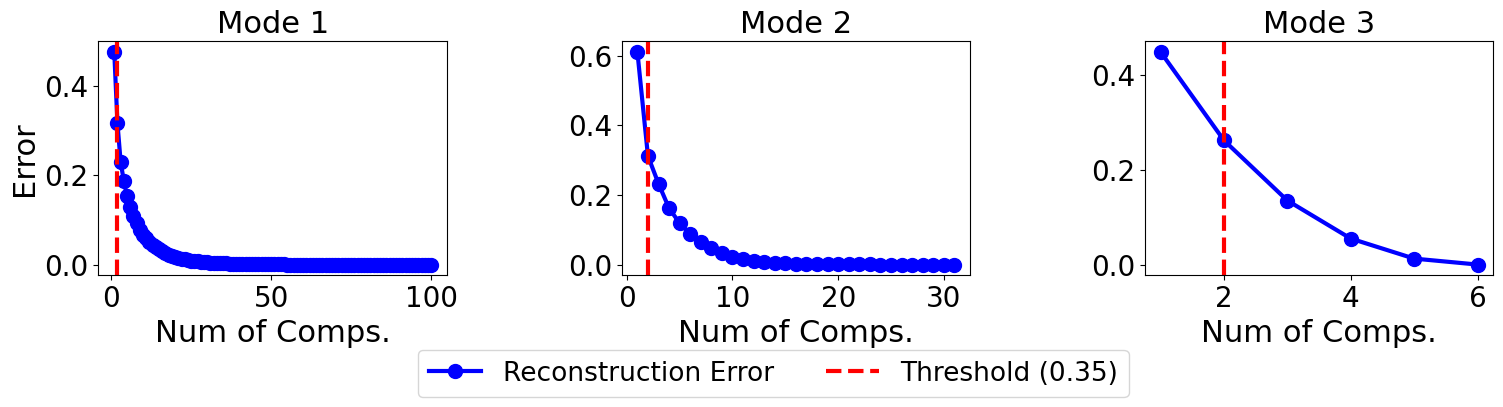

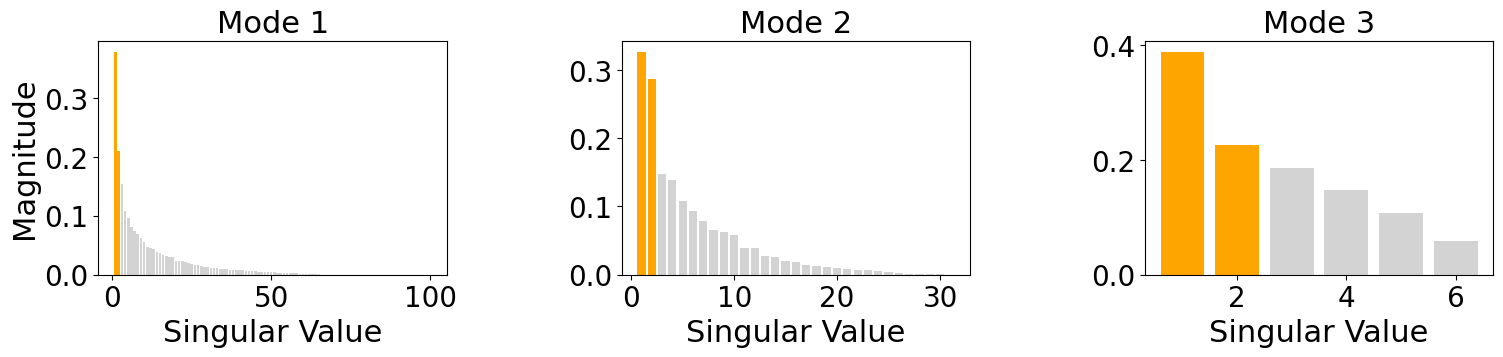

Results for tensor_70 and error_threshold=0.4


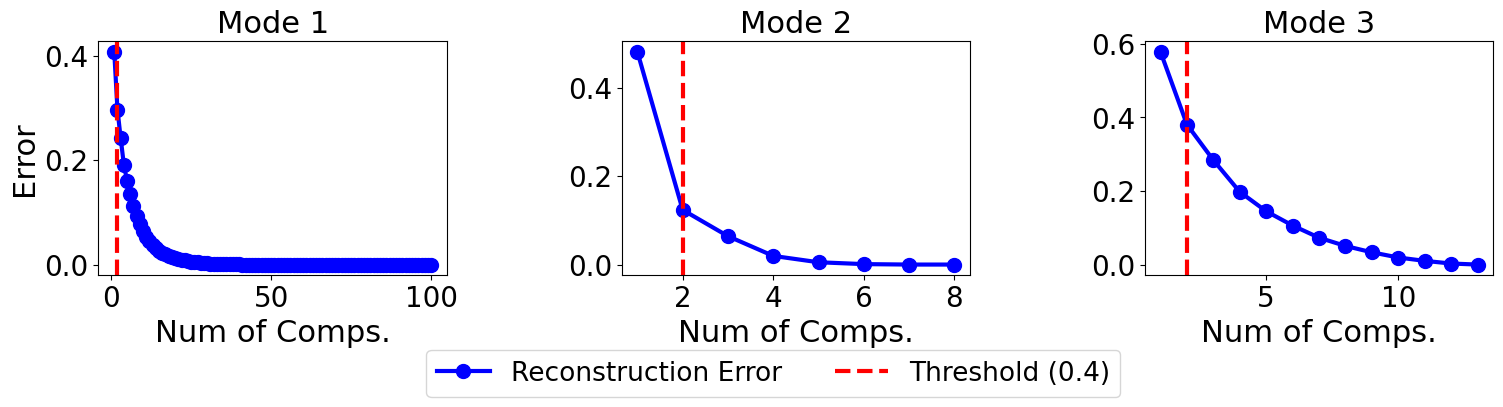

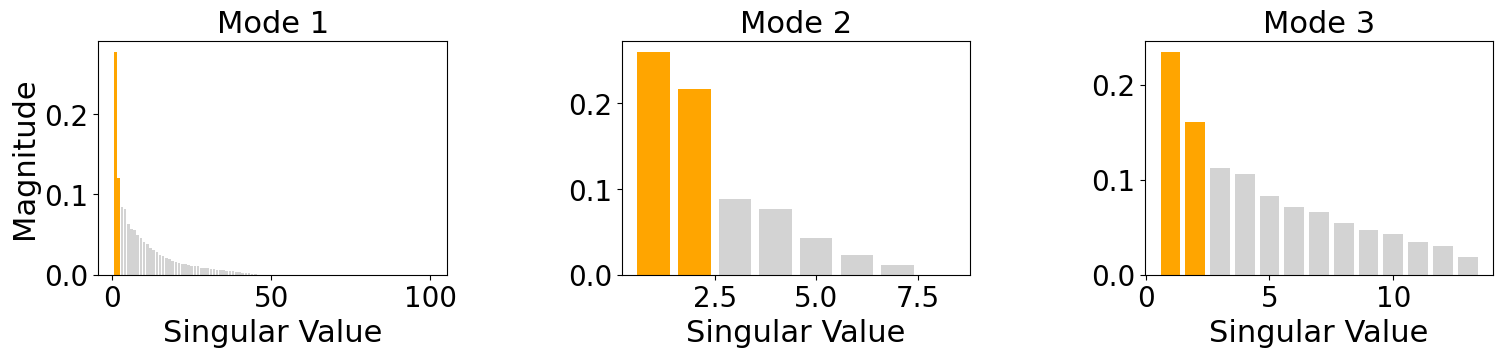

Results for tensor_100 and error_threshold=0.4


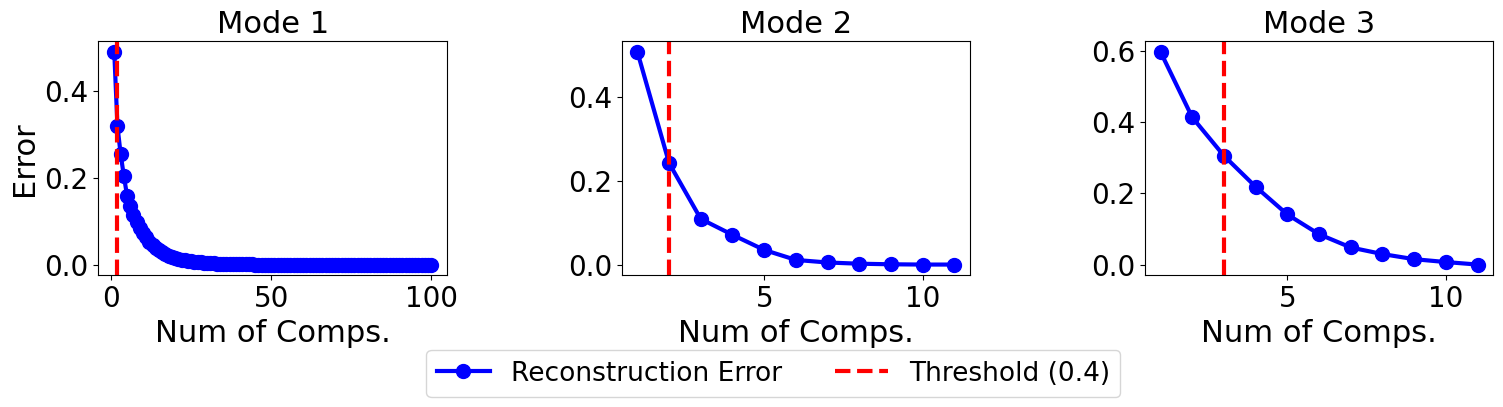

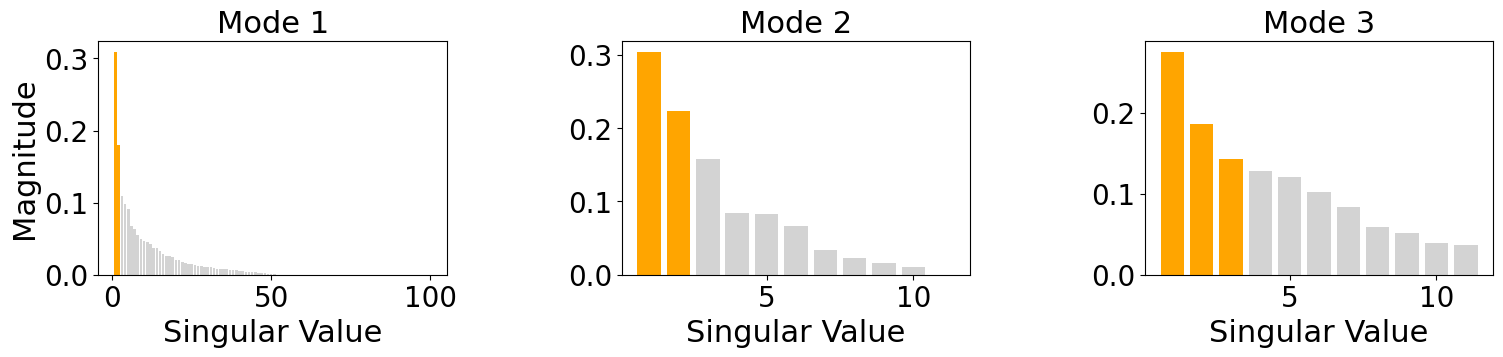

Results for tensor_200 and error_threshold=0.4


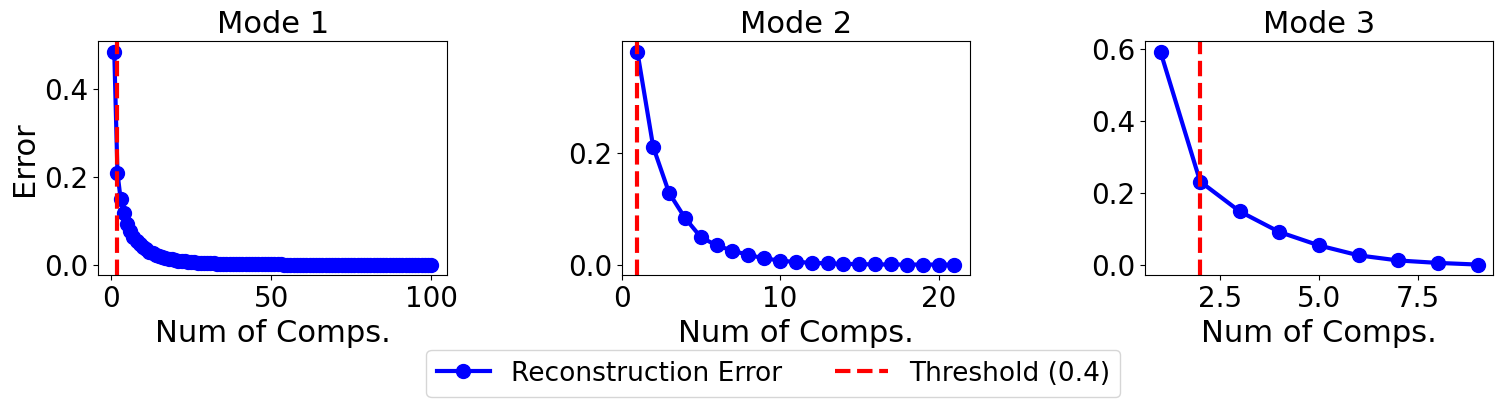

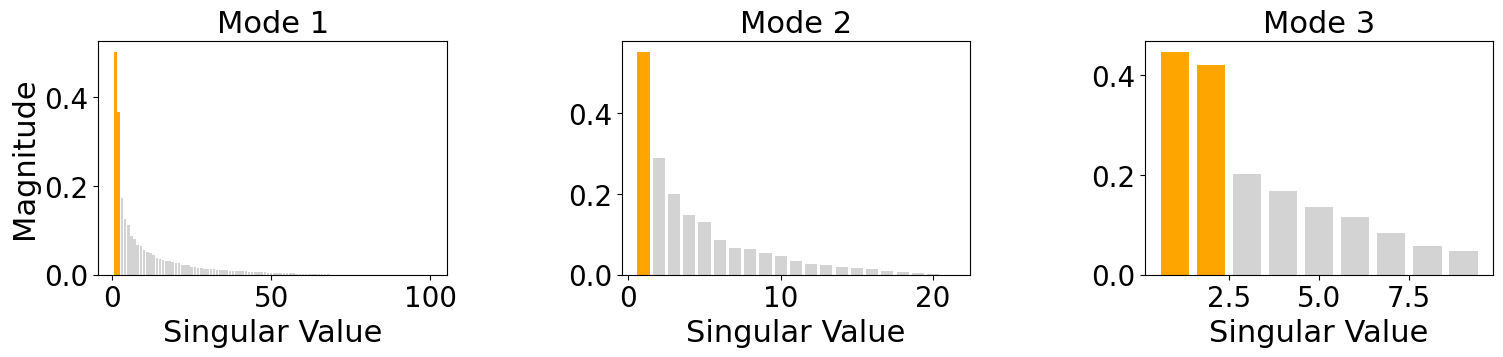

Results for tensor_300 and error_threshold=0.4


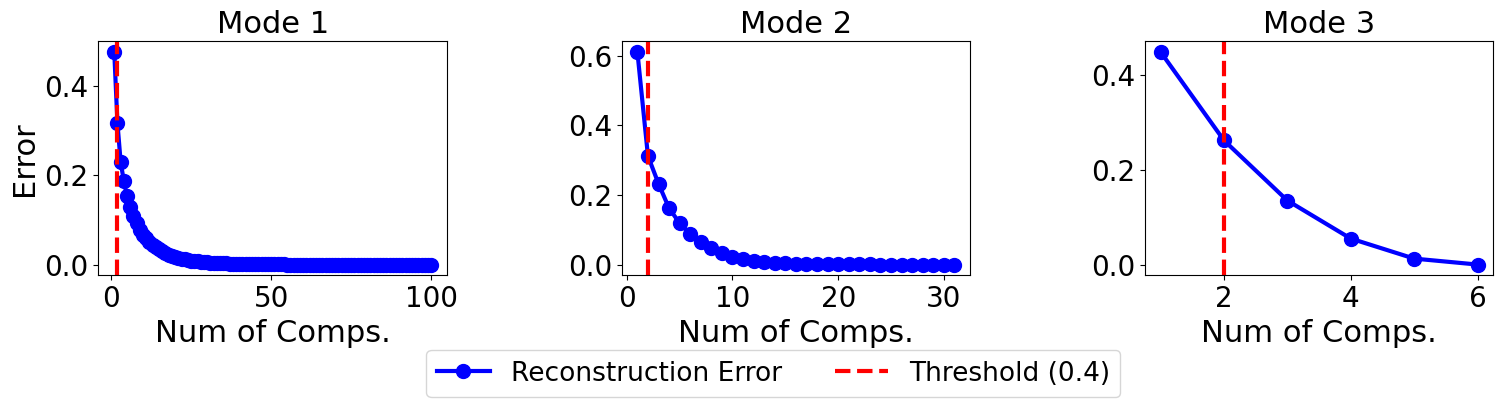

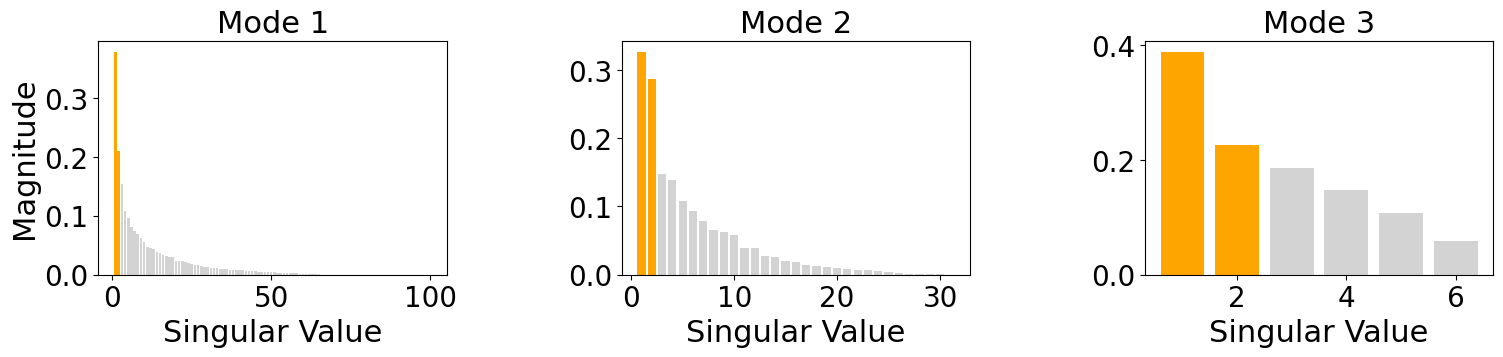

RESULTS SUMMARY

  * Results for threshold = 0.1
Final Ranks for tensor_70 (threshold=0.1): [8, 3, 7]
Final Ranks for tensor_100 (threshold=0.1): [8, 4, 6]
Final Ranks for tensor_200 (threshold=0.1): [5, 4, 4]
Final Ranks for tensor_300 (threshold=0.1): [8, 6, 4]

  * Results for threshold = 0.15
Final Ranks for tensor_70 (threshold=0.15): [6, 2, 5]
Final Ranks for tensor_100 (threshold=0.15): [6, 3, 5]
Final Ranks for tensor_200 (threshold=0.15): [3, 3, 3]
Final Ranks for tensor_300 (threshold=0.15): [6, 5, 3]

  * Results for threshold = 0.2
Final Ranks for tensor_70 (threshold=0.2): [4, 2, 4]
Final Ranks for tensor_100 (threshold=0.2): [5, 3, 5]
Final Ranks for tensor_200 (threshold=0.2): [3, 3, 3]
Final Ranks for tensor_300 (threshold=0.2): [4, 4, 3]

  * Results for threshold = 0.25
Final Ranks for tensor_70 (threshold=0.25): [3, 2, 4]
Final Ranks for tensor_100 (threshold=0.25): [4, 2, 4]
Final Ranks for tensor_200 (threshold=0.25): [2, 2, 2]
Final Ranks for tensor_300 (threshold

In [44]:
thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
all_errors_by_threshold_real = {}

# Run SVD_components for each threshold
for threshold in thresholds:
    errors = SVD_components(tensors_real, tensor_real_names, error_threshold=threshold)
    all_errors_by_threshold_real[threshold] = errors

# Now print nicely
print('RESULTS SUMMARY')
for threshold, errors in all_errors_by_threshold_real.items():
    print(f"\n  * Results for threshold = {threshold}")
    for j, tensor in enumerate(tensors_real):
        tensor_name = tensor_real_names[j]
        print(f"Final Ranks for tensor_{tensor_name} (threshold={threshold}): {errors[j]}")


## Simulated data

Results for tensor_1 and error_threshold=0.1


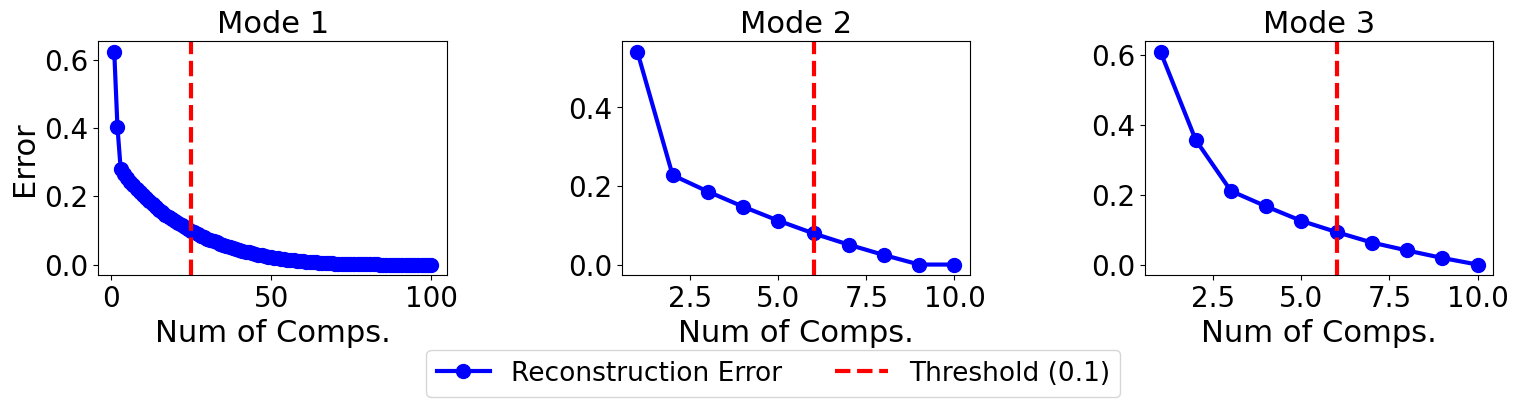

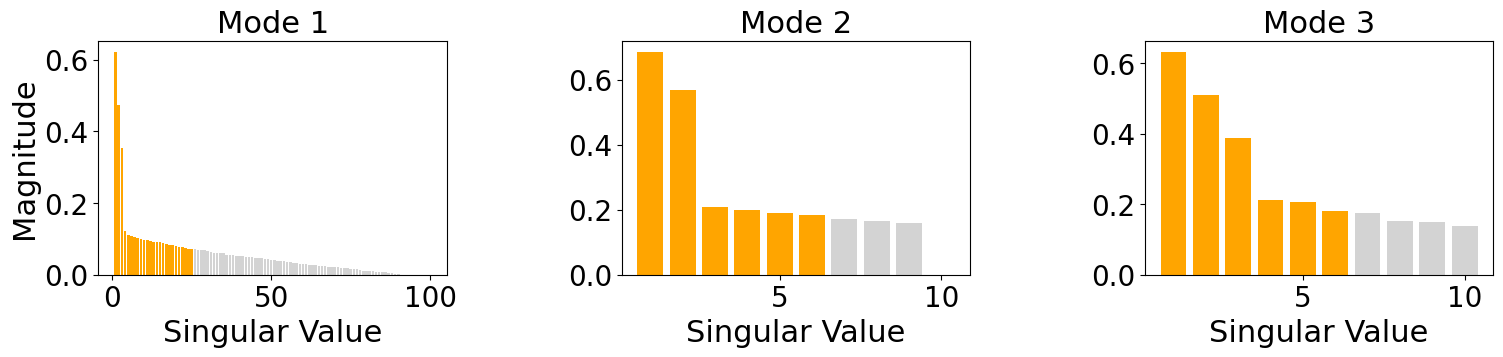

Results for tensor_2 and error_threshold=0.1


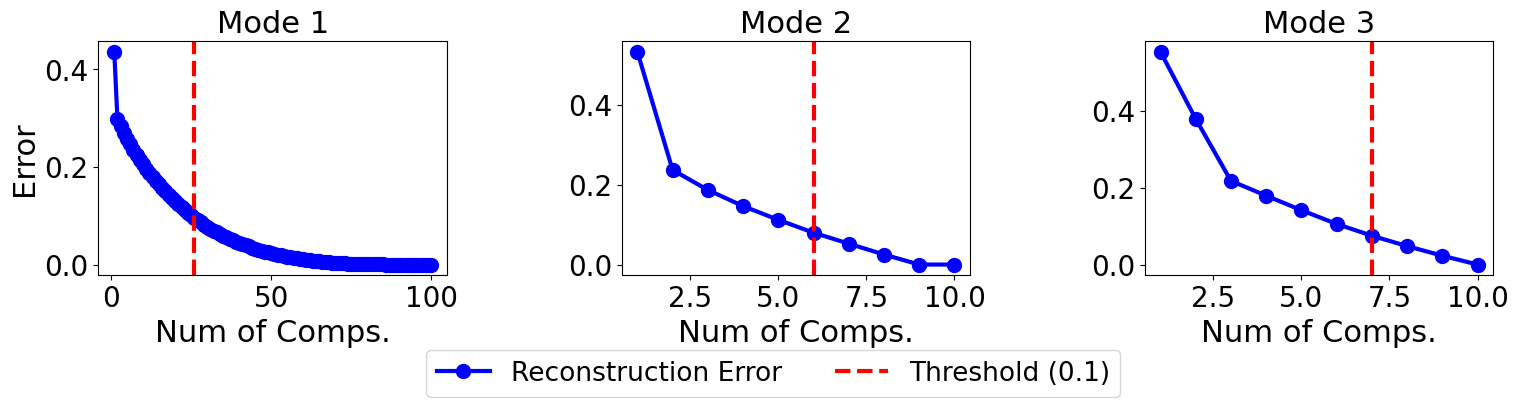

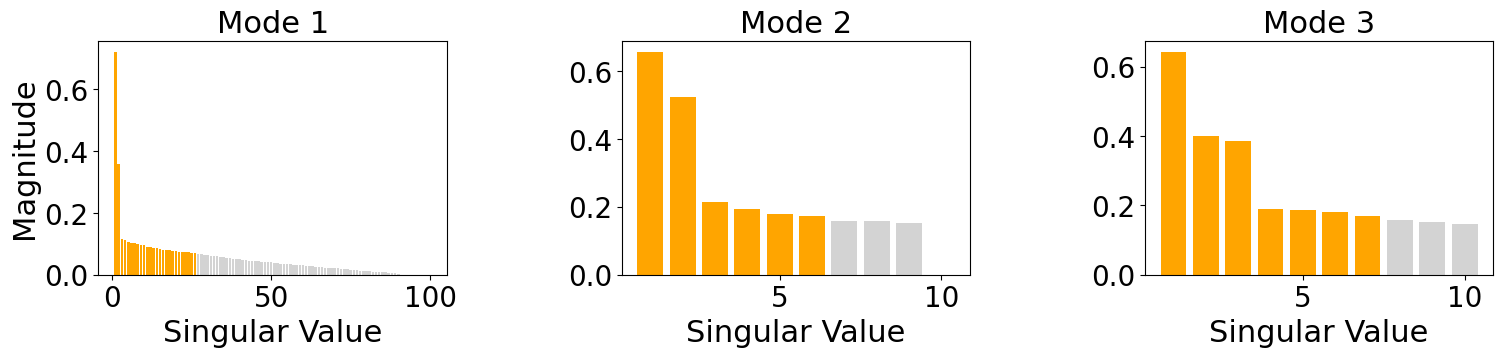

Results for tensor_1 and error_threshold=0.15


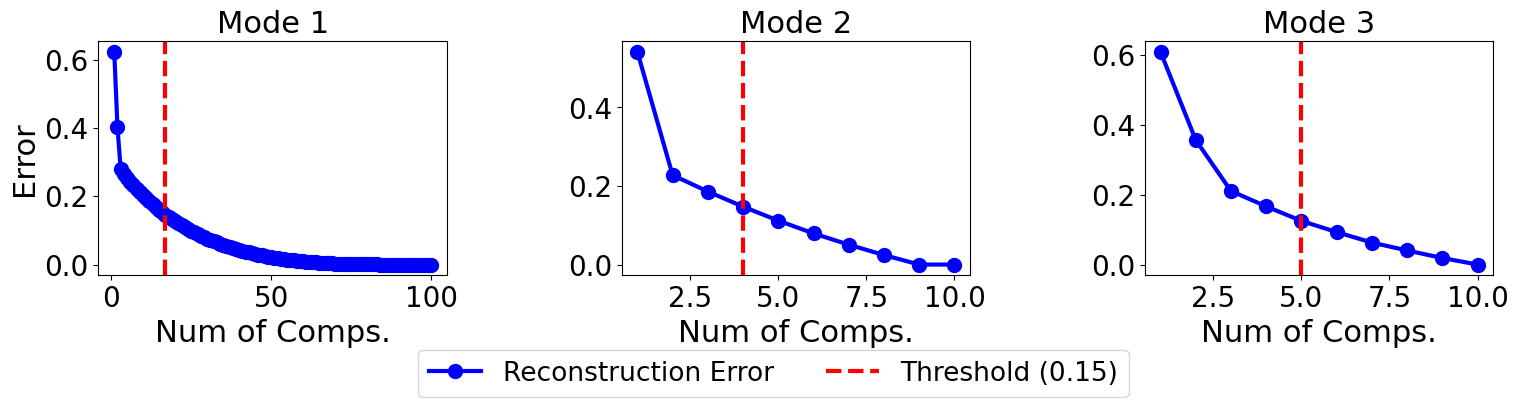

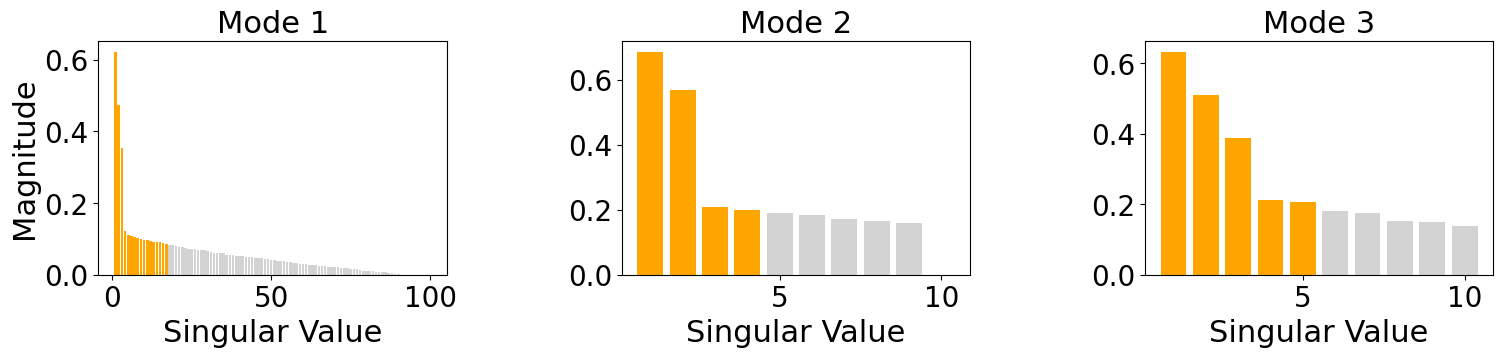

Results for tensor_2 and error_threshold=0.15


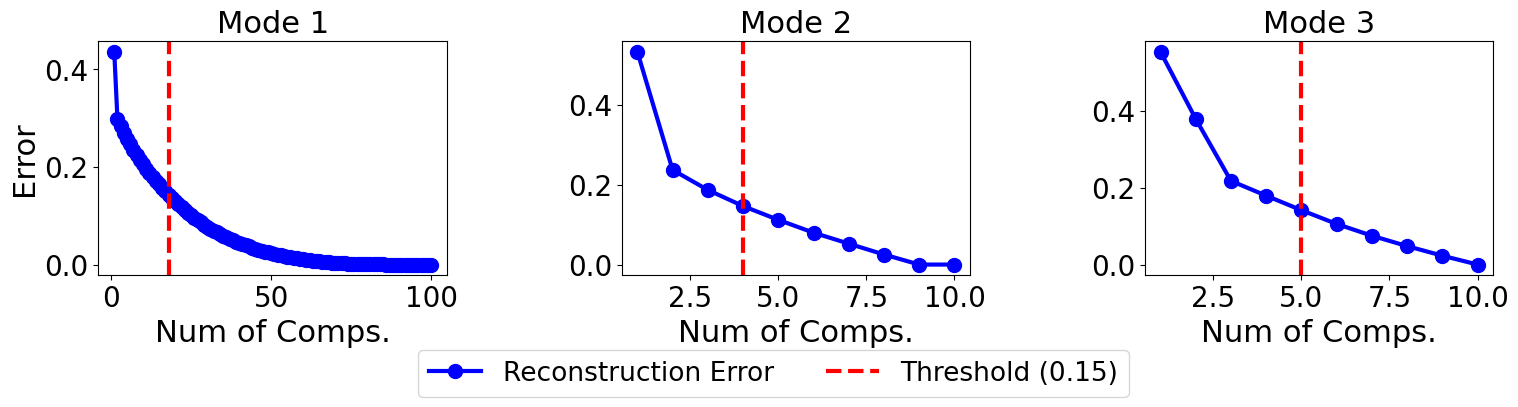

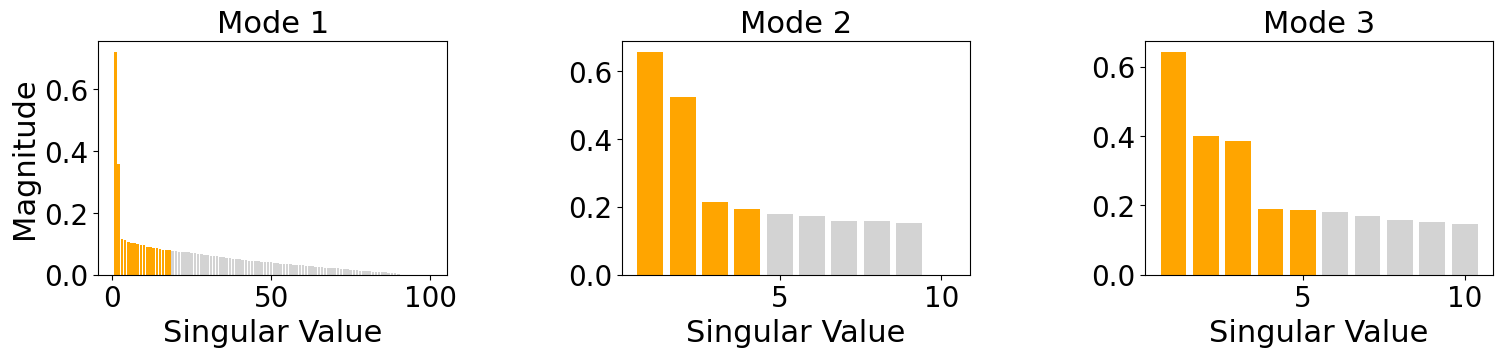

Results for tensor_1 and error_threshold=0.2


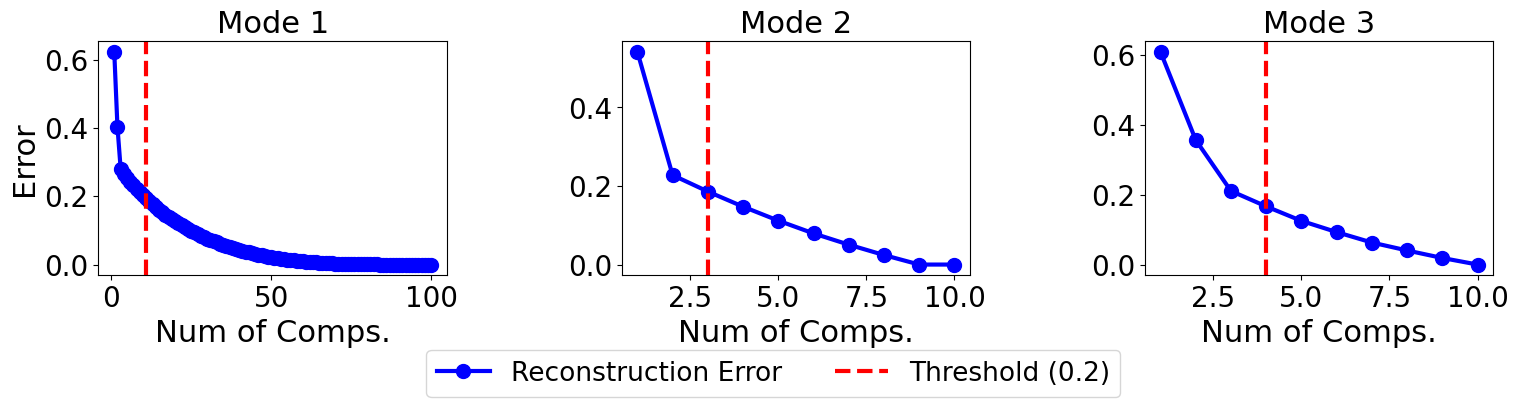

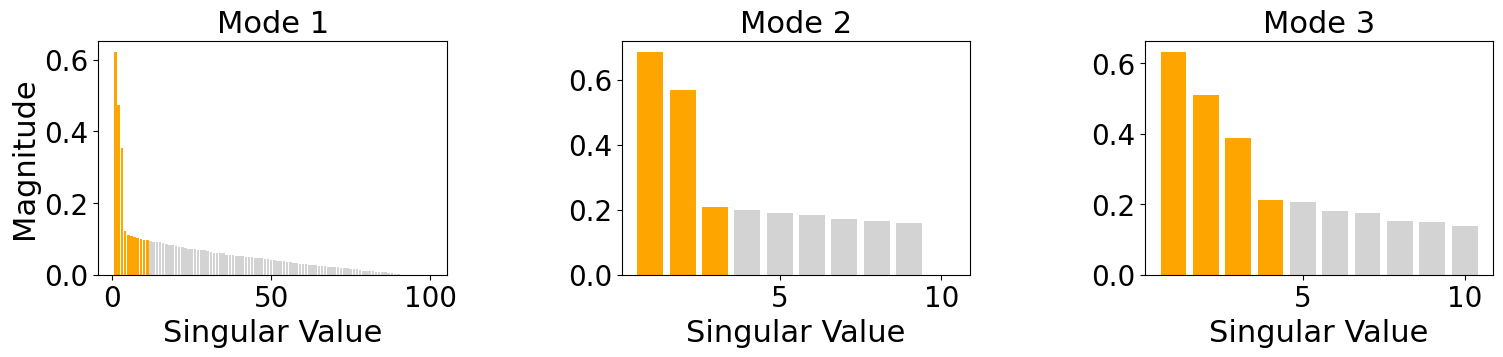

Results for tensor_2 and error_threshold=0.2


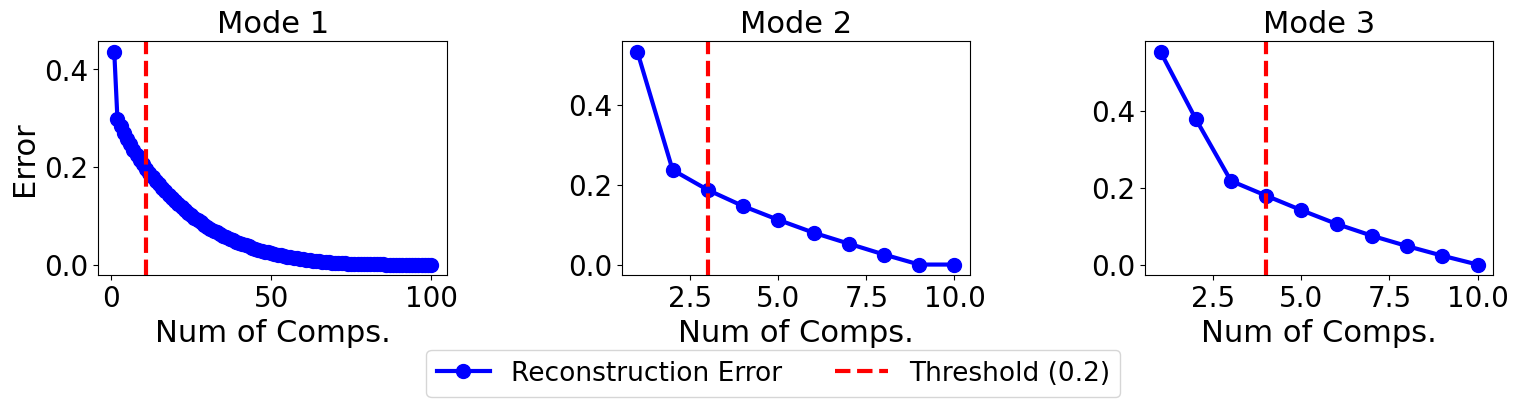

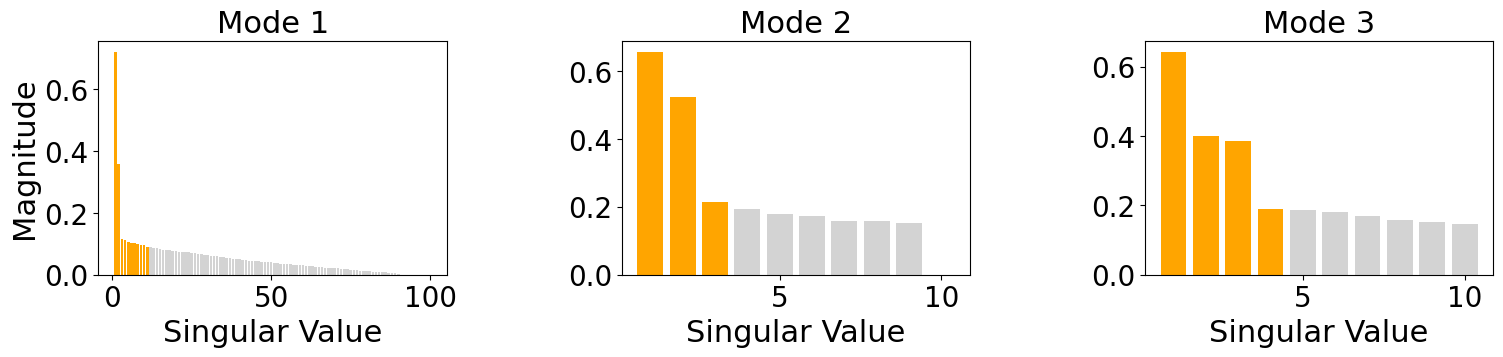

Results for tensor_1 and error_threshold=0.25


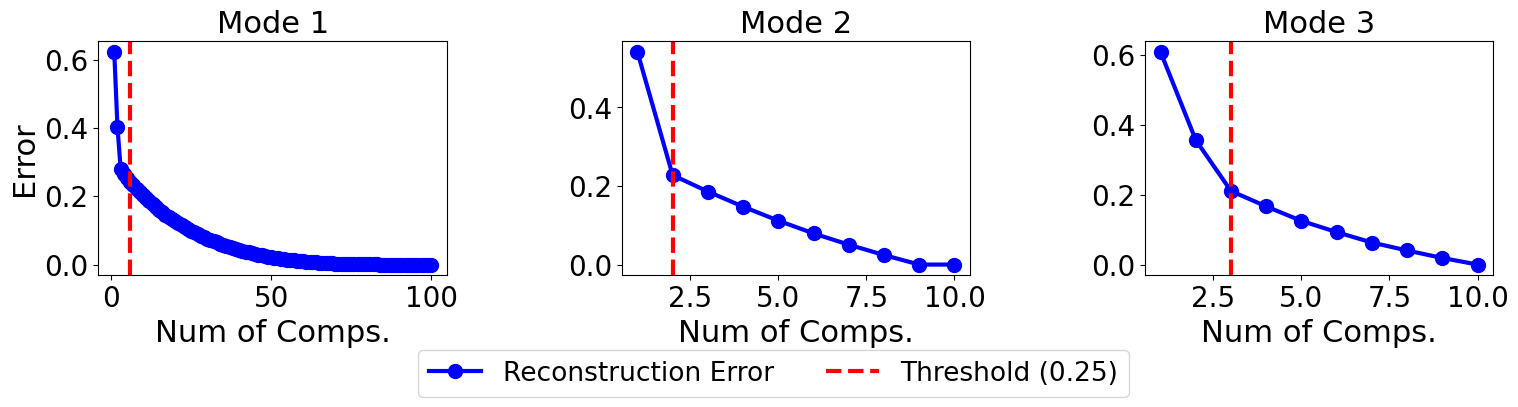

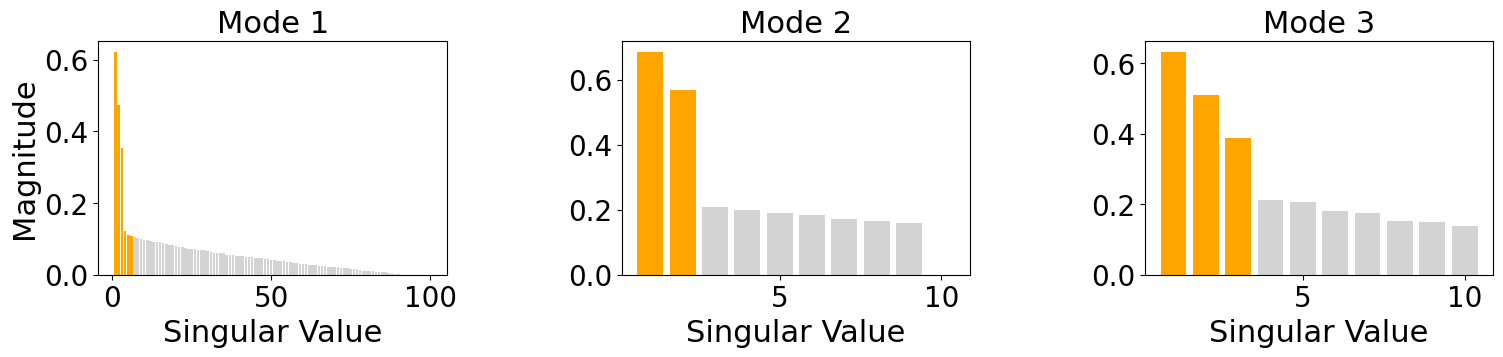

Results for tensor_2 and error_threshold=0.25


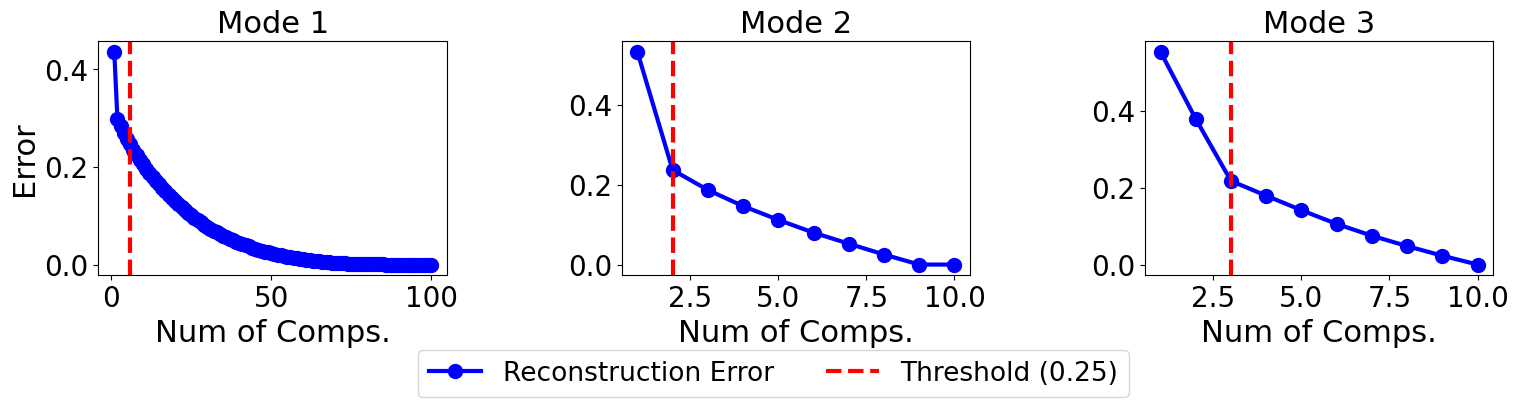

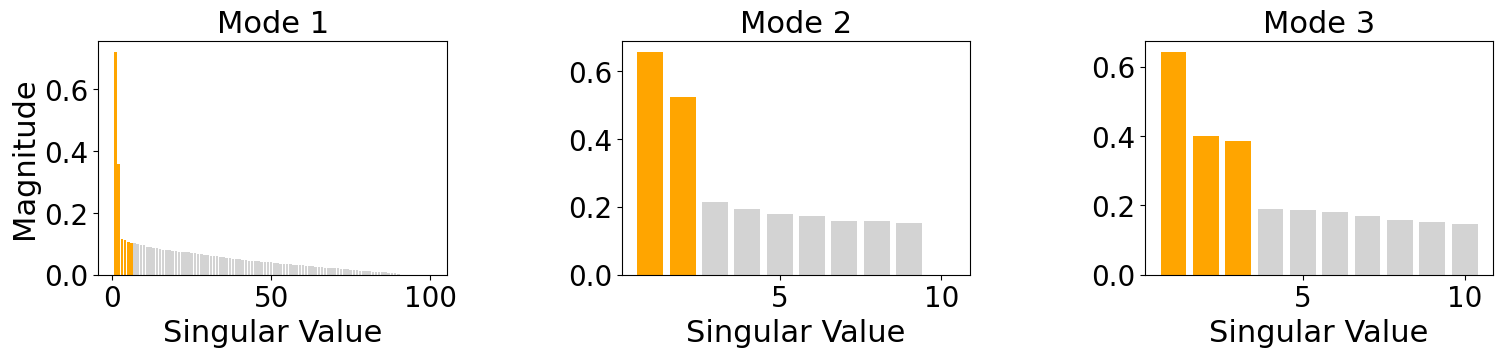

Results for tensor_1 and error_threshold=0.3


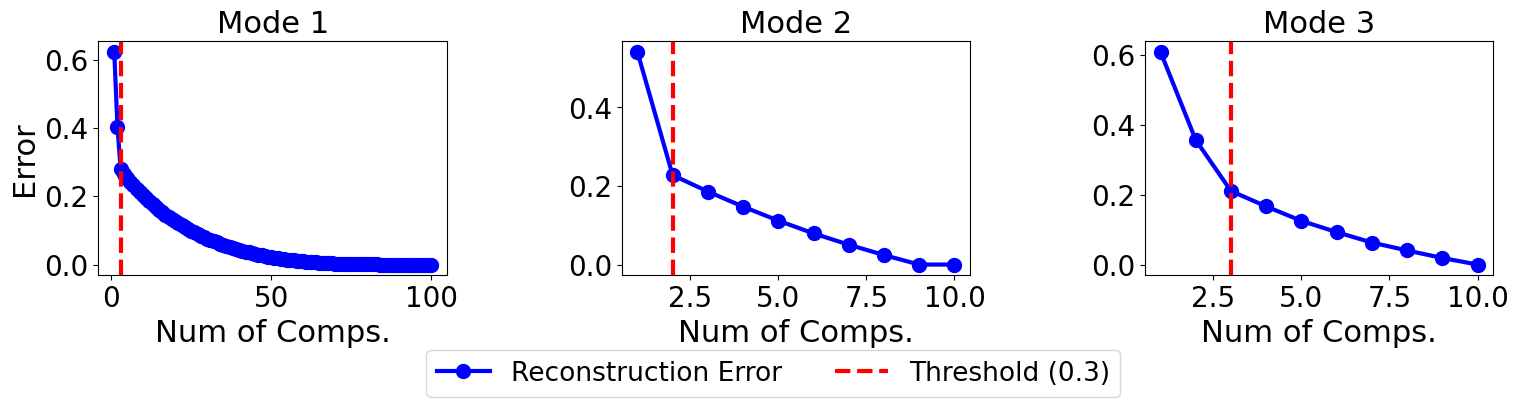

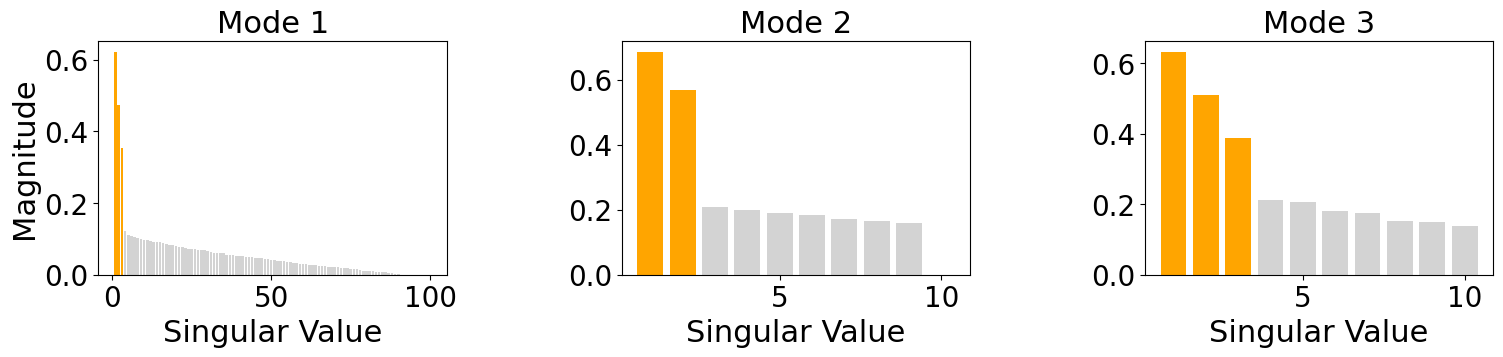

Results for tensor_2 and error_threshold=0.3


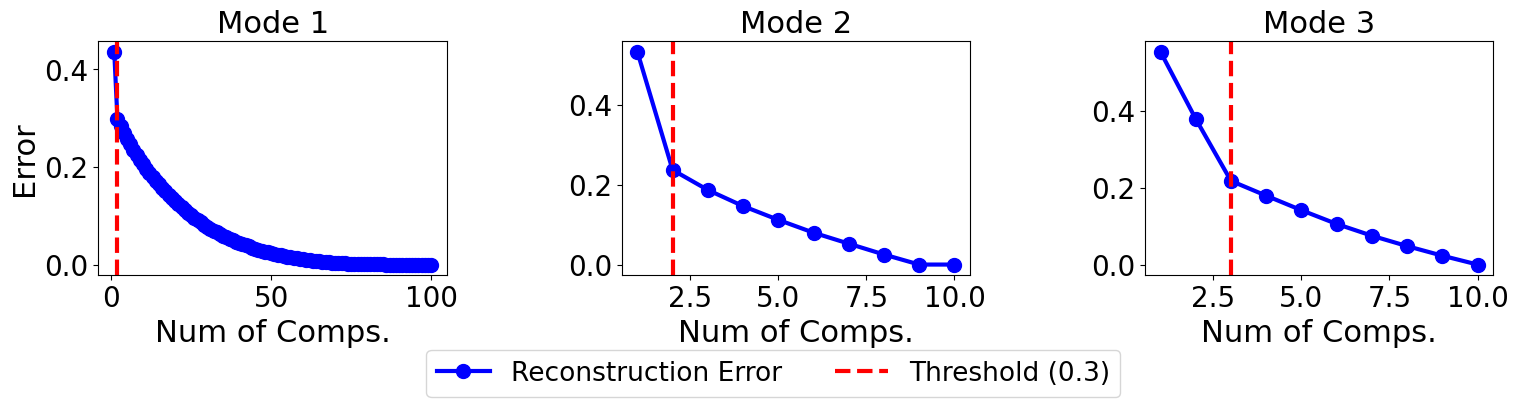

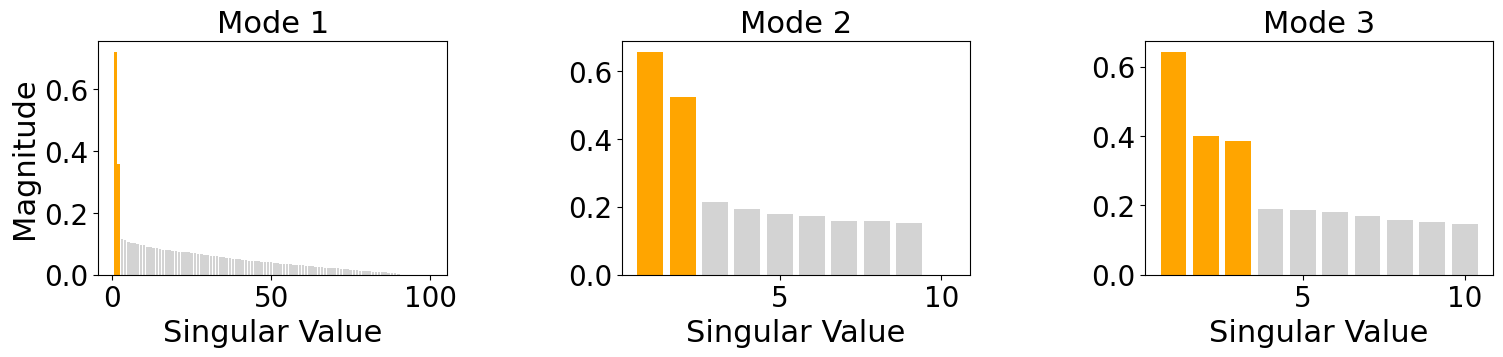

Results for tensor_1 and error_threshold=0.35


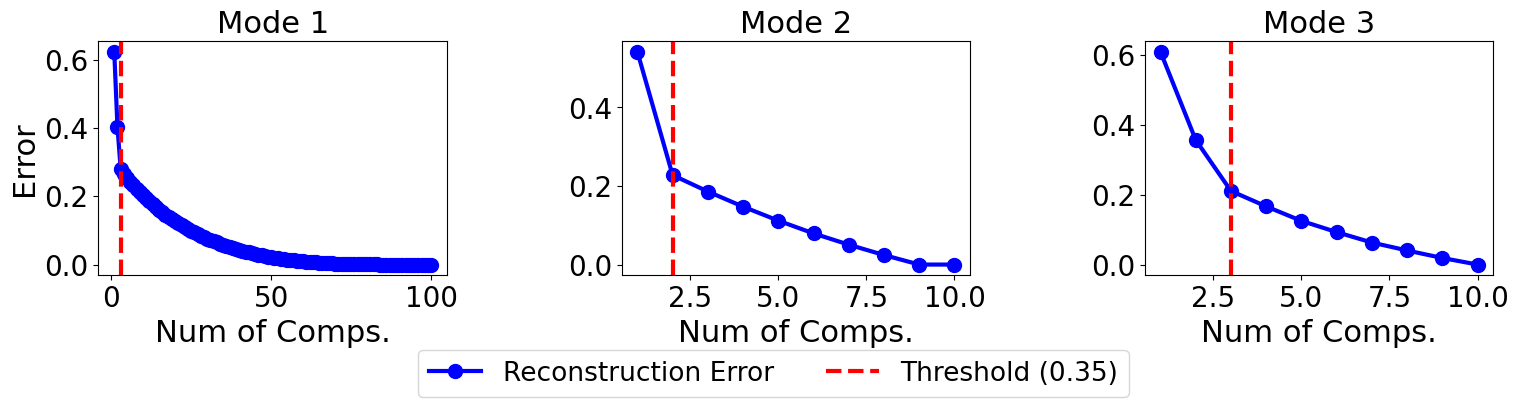

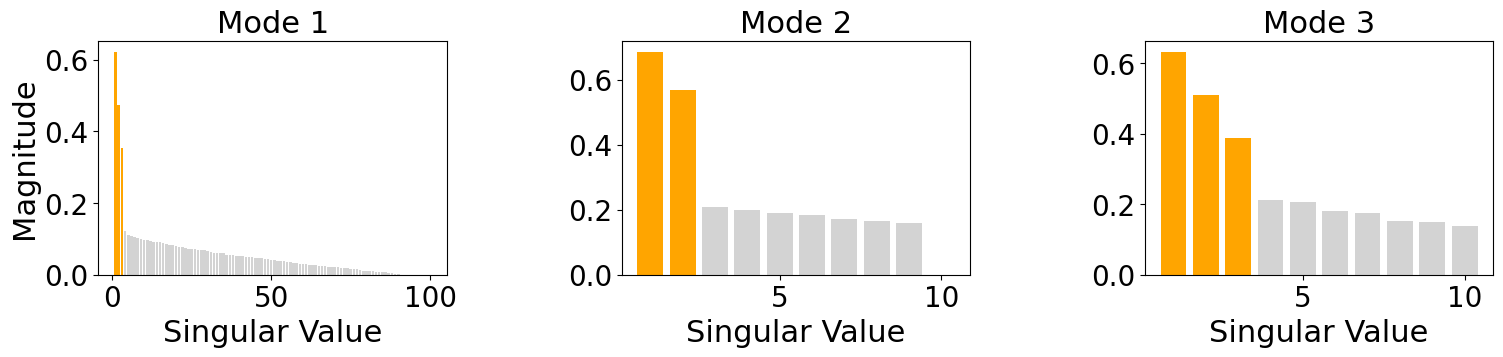

Results for tensor_2 and error_threshold=0.35


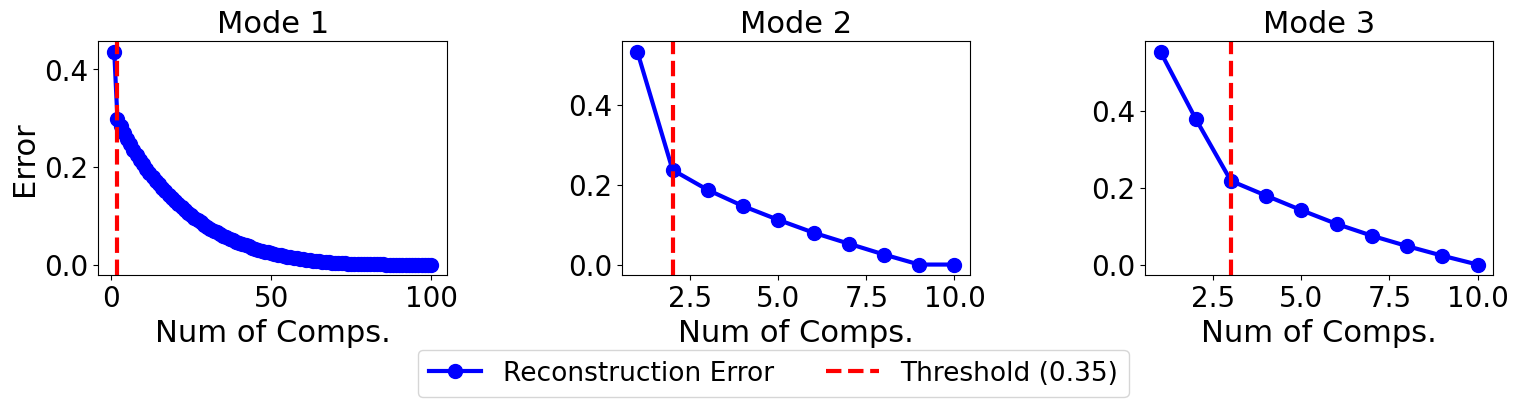

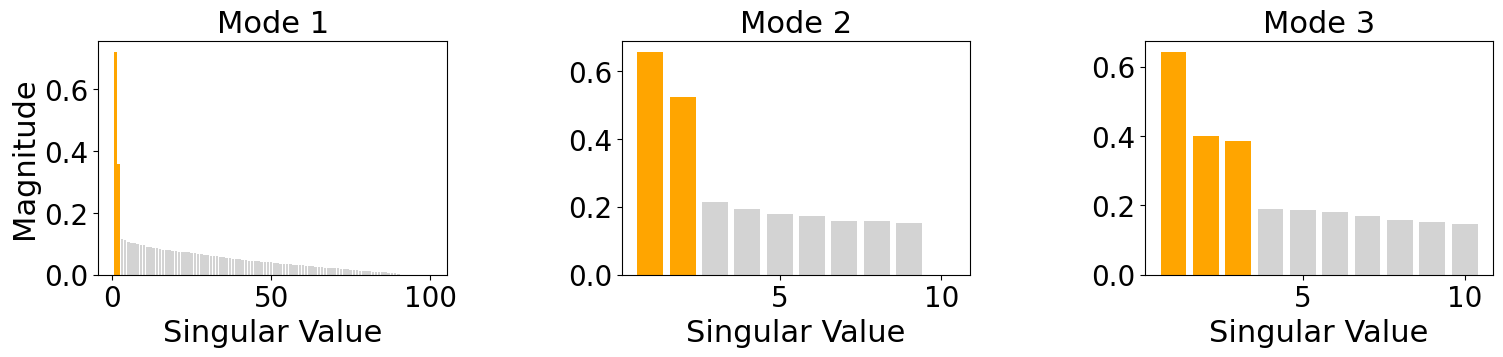

Results for tensor_1 and error_threshold=0.4


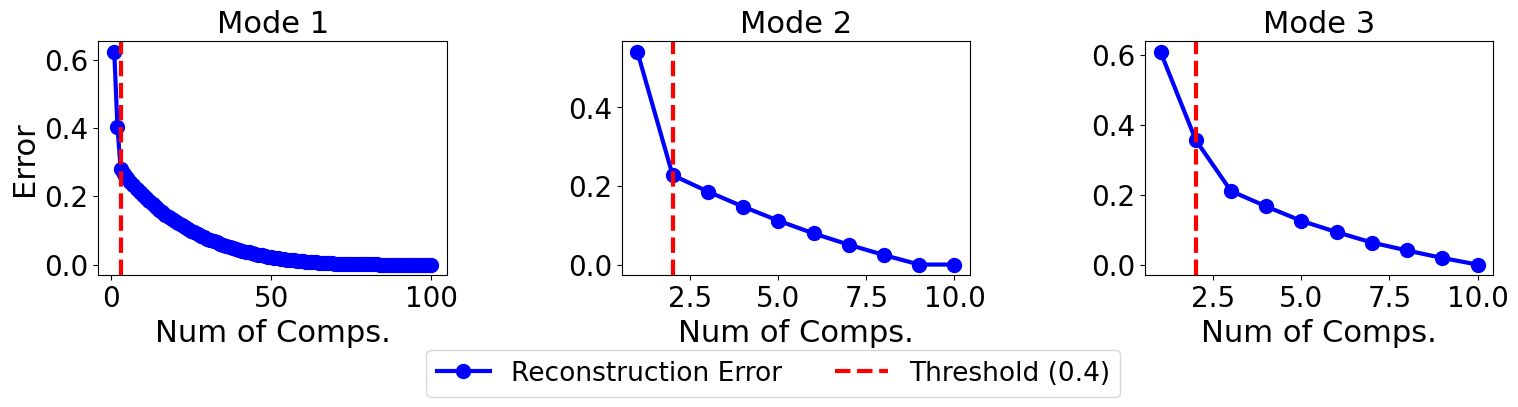

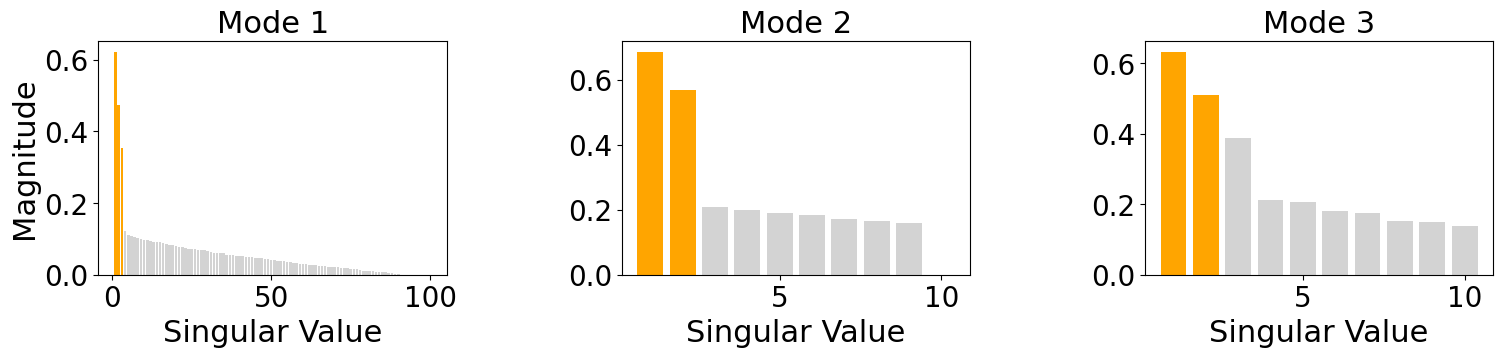

Results for tensor_2 and error_threshold=0.4


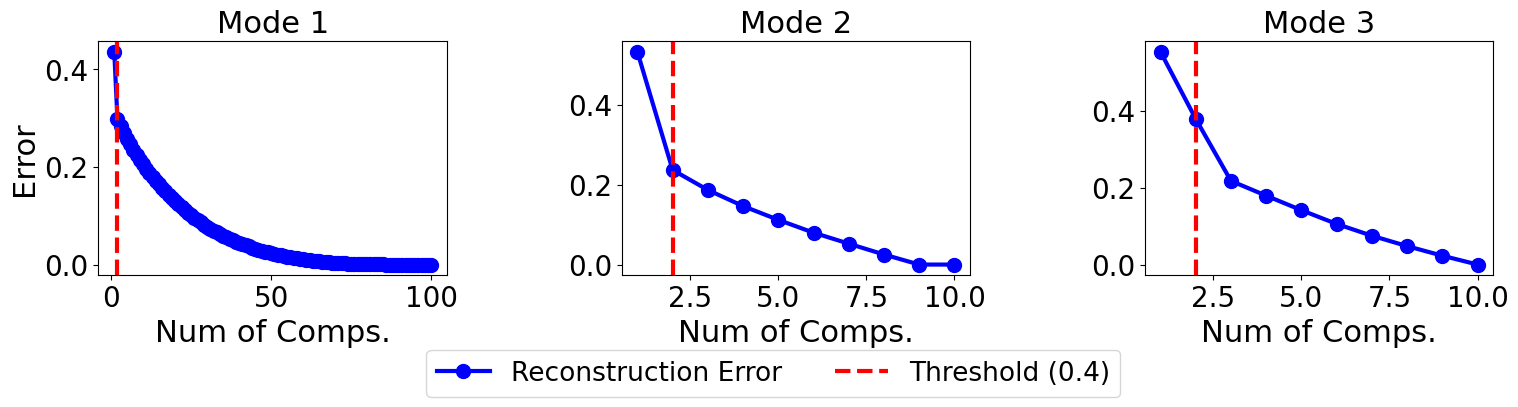

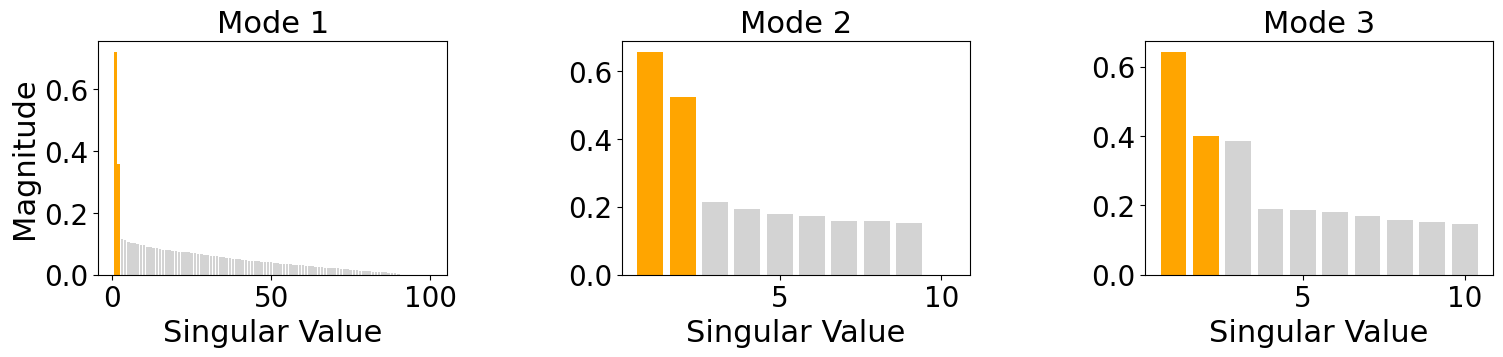


Results for threshold = 0.1
Final Ranks for tensor_1 (threshold=0.1): [25, 6, 6]
Final Ranks for tensor_2 (threshold=0.1): [26, 6, 7]

Results for threshold = 0.15
Final Ranks for tensor_1 (threshold=0.15): [17, 4, 5]
Final Ranks for tensor_2 (threshold=0.15): [18, 4, 5]

Results for threshold = 0.2
Final Ranks for tensor_1 (threshold=0.2): [11, 3, 4]
Final Ranks for tensor_2 (threshold=0.2): [11, 3, 4]

Results for threshold = 0.25
Final Ranks for tensor_1 (threshold=0.25): [6, 2, 3]
Final Ranks for tensor_2 (threshold=0.25): [6, 2, 3]

Results for threshold = 0.3
Final Ranks for tensor_1 (threshold=0.3): [3, 2, 3]
Final Ranks for tensor_2 (threshold=0.3): [2, 2, 3]

Results for threshold = 0.35
Final Ranks for tensor_1 (threshold=0.35): [3, 2, 3]
Final Ranks for tensor_2 (threshold=0.35): [2, 2, 3]

Results for threshold = 0.4
Final Ranks for tensor_1 (threshold=0.4): [3, 2, 2]
Final Ranks for tensor_2 (threshold=0.4): [2, 2, 2]


In [45]:
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
all_errors_by_threshold_sim = {}

# Run SVD_components for each threshold
for threshold in thresholds:
    errors = SVD_components(tensors_sim, tensor_sim_names, error_threshold=threshold)
    all_errors_by_threshold_sim[threshold] = errors

# Now print nicely
for threshold, errors in all_errors_by_threshold_sim.items():
    print(f"\nResults for threshold = {threshold}")
    for j, tensor in enumerate(tensors_sim):
        tensor_name = tensor_sim_names[j]
        print(f"Final Ranks for tensor_{tensor_name} (threshold={threshold}): {errors[j]}")

## Plotting threshold effects

Next, we aim to see how the number of components changes for the tested thresholds.

In [46]:
results_threshold = {}
for threshold in thresholds:
    results_threshold[threshold] = {}
    for i in range(len(all_errors_by_threshold_real[threshold])):
        results_threshold[threshold]["tensor_"+tensor_real_names[i]] = all_errors_by_threshold_real[threshold][i]
    for j in range(len(all_errors_by_threshold_sim[threshold])):
        results_threshold[threshold]["tensor_"+tensor_sim_names[j]] = all_errors_by_threshold_sim[threshold][j]

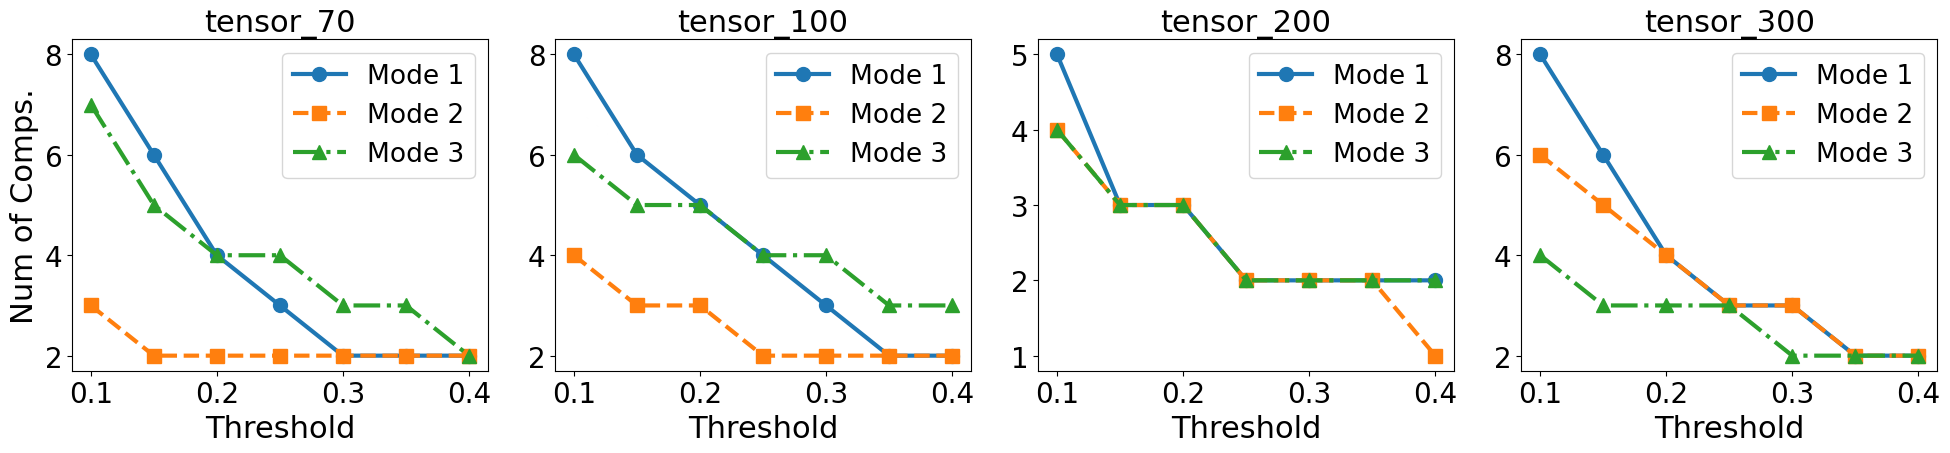

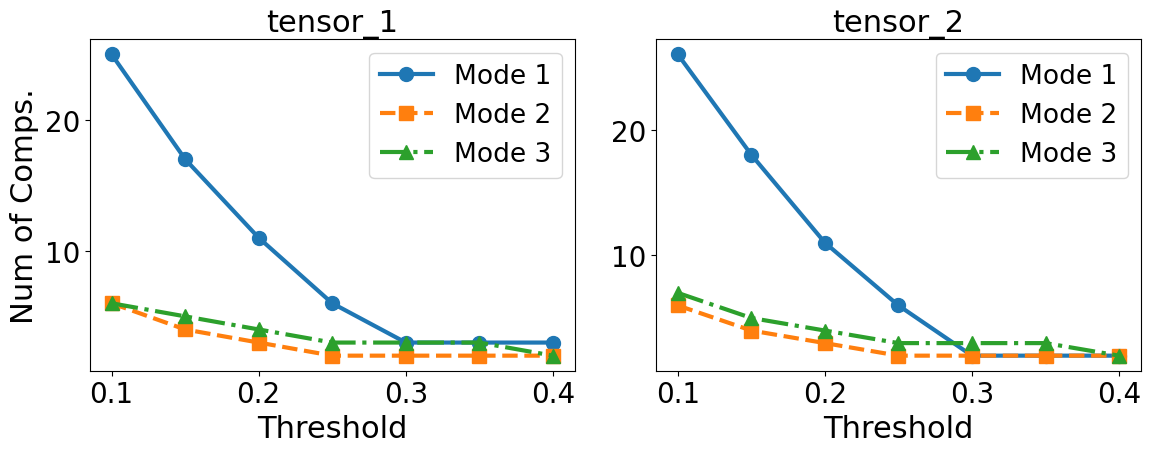

In [47]:
thresholds = sorted(results_threshold.keys())
tensor_names_fig1 = ['tensor_70', 'tensor_100', 'tensor_200', 'tensor_300']
tensor_names_fig2 = ['tensor_1', 'tensor_2']
modes = [0, 1, 2]

line_styles = ['-', '--', '-.']
markers = ['o', 's', '^']

# Figure 1: 4 tensors
fig1, axes1 = plt.subplots(1, 4, figsize=(20, 5))
for idx, tensor_name in enumerate(tensor_names_fig1):
    ax = axes1[idx]
    modes_data = {mode: [] for mode in modes}
    
    for threshold in thresholds:
        ranks = results_threshold[threshold][tensor_name]
        for mode in modes:
            modes_data[mode].append(ranks[mode])
    
    for mode in modes:
        ax.plot(thresholds, modes_data[mode],
                linestyle=line_styles[mode],
                marker=markers[mode],
                label=f'Mode {mode+1}')
    
    ax.set_title(tensor_name)
    ax.set_xlabel('Threshold')
    if idx == 0:
        ax.set_ylabel('Num of Comps.')
    ax.legend()

fig1.tight_layout()
save_figure(fig1,'components_vs_threshold_real', foldername=None)
plt.show()

# Figure 2: 2 tensors
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
for idx, tensor_name in enumerate(tensor_names_fig2):
    ax = axes2[idx]
    modes_data = {mode: [] for mode in modes}
    
    for threshold in thresholds:
        ranks = results_threshold[threshold][tensor_name]
        for mode in modes:
            modes_data[mode].append(ranks[mode])
    
    for mode in modes:
        ax.plot(thresholds, modes_data[mode],
                linestyle=line_styles[mode],
                marker=markers[mode],
                label=f'Mode {mode+1}')
    
    ax.set_title(tensor_name)
    ax.set_xlabel('Threshold')
    if idx == 0:
        ax.set_ylabel('Num of Comps.')
    ax.legend()

fig2.tight_layout()
save_figure(fig2,'components_vs_threshold_sim', foldername=None)
plt.show()
